### Ορφανουδάκης Φίλιππος-Σκόβελεφ
### ΑΜ :03400107
### ΕΔΕΜΜ

### Αρχική Ανάλυση και Υποθέσεις

Στο πλαίσιο της εργασίας μας δίνονται δεδομένα από accelerometer στους άξονες x-y-z, από gyroscope στους άξονες x-y-z και location speed.

Το ζητούμενο της άσκησης είναι να εκτιμηθούν ποιές τιμές είναι αποτέλεσμα ενός harsh cornering.

Πολύ συνοπτικά θα αναφέρουμε τον τρόπο που δουλέψαμε και στη συνέχεια θα εμβαθύνουμε στο κάθε κομμάτι ξεχωριστά.

Αρχικά μελετώντας την βιβλιογραφία εντοπίσαμε ότι στην κατηγορία harsh events τοποθετούνται τα εξής :



*   Rapid/Sudden acceleration
*   Harsh braking
*   Harsh left/right turns

Συνεπώς σε πρώτο στάδιο εφαρμόσαμε ορισμένες τεχνικές unsupervised learning με τις οποίες μπορέσαμε να χαρακτηρίσουμε ποίες από τις τιμές ανήκουν στην γενική κατηγορία harsh events. Οι τεχνικές αυτές στοχεύουν στο outlier detection.

Στη συνέχεια έχοντας τα αποτελέσματα από κάθε αλγόριθμο εντοπισμού outlier αποφασίζουμε να εφαρμόσουμε ενα voting σύστημα κατα το οποίο κατηγοριοποιούμε ως outlier όσα σημεία βρέθηκαν στην πλειοψηφία των αλγορίθμων και όχι απαραίτητα σε όλους, καθώς ορισμένοι αλγόριθμοι μπορεί να μην εξυπηρετούν σε απόλυτο βαθμό τις συγκεκριμένες ανάγκες του προβλήματος.

Τέλος έχοντας συγκεντρώσει τα harsh events αποφασίζουμε να κάνουμε έναν επιπλέον καθαρισμό με την εφαρμογή κάποιων κανόνων που διαφοροποιούν το harsh cornering από τα υπόλοιπα 2 harsh events. Οι κανόνες που εφαρμόσαμε , τους οποίους θα αναλύσουμε στη συνέχεια, είναι οι εξής :



*   Αρνητική επιτάχυνση στον άξονα κίνησης (x)
*   Μεγάλη απόλυτη τιμή επιτάχυνσης στον πλαϊνό άξονα (y)
*   Μεγάλη απόλυτη τιμή περιστροφής στον κάθετο άξονα  (z)


Στο σημείο αυτό θα θέλαμε να παραθέσουμε τις υποθέσεις που κάνουμε για τα συγκεκριμένα δεδομένα καθώς δεν διαθέτουμε εξειδικευμένη domain γνώση.

Τα δεδομένα γνωρίζουμε ότι είναι από έναν οδηγό, συνεπώς αναμένουμε ομοίομορφη συμπεριφορική οδήγηση και ίσα μοιρασμένα harsh events. Υποθέτουμε ότι η δειγματοληψία γίνεται σε περίοδο περίπου **0.1 - 1** δευτερόλεπτο. Συνεπώς εμείς διαθέτουμε 103891 μετρήσεις, οι οποίες μπορούν να μεταφραστούν σε 28,85 ώρες ( θεωρούμε ότι η περίοδος δειγματοληψίας είναι 1 δευτερόλεπτο). Η σκέψη που κάναμε για να καταλήξουμε σε έναν αριθμό harsh cornerings είναι ότι ένα μέσο ταξίδι διαρκεί περίπου **30 λεπτά**, επομένως έχουμε 3463 ταξίδια και θεωρούμε ότι σε κατα μέσο όρο συμβαίνει περίπου **1** harsh cornering ανά ταξίδι επομένως στοχεύουμε περίπου στο 3-4 % των σημείων μας να είναι harsh cornerings. Από την εμπειρία μας θεωρούμε ότι απο τα 3 harsh events , αυτό που συναντάται πιο σπάνια είναι το harsh cornering. Φυσικά οι παράμετροι των αλγορίθμων μας μπορούν να αλλάξουν και να οδηγηθούμε σε διαφορετικά νούμερα, ανάλογα με την γνώση ενός ειδικού και τις ανάγκες του προβλήματος.


### Ανάγνωση και αναπαράσταση Δεδομένων

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data_Driven/all_LAT_uns.csv')
outlier = df.copy(deep = True)

In [4]:
df

NewAccelX  NewAccelY  ...  NewRotRateZ  locationSpeed
0           0.001     -0.002  ...        0.000            0.0
1           0.007      0.000  ...        0.000            0.0
2           0.008      0.004  ...       -0.001            0.0
3           0.008      0.002  ...       -0.001            0.0
4           0.009      0.001  ...        0.002            0.0
...           ...        ...  ...          ...            ...
103886      0.009     -0.001  ...        0.004            0.0
103887     -0.014     -0.067  ...       -0.001            0.0
103888     -0.005      0.022  ...        0.001            0.0
103889      0.022     -0.009  ...        0.003            0.0
103890      0.002      0.007  ...        0.013            0.0

[103891 rows x 7 columns]

#### Χρονοσειρά των πρώτων 5000 σημειών 

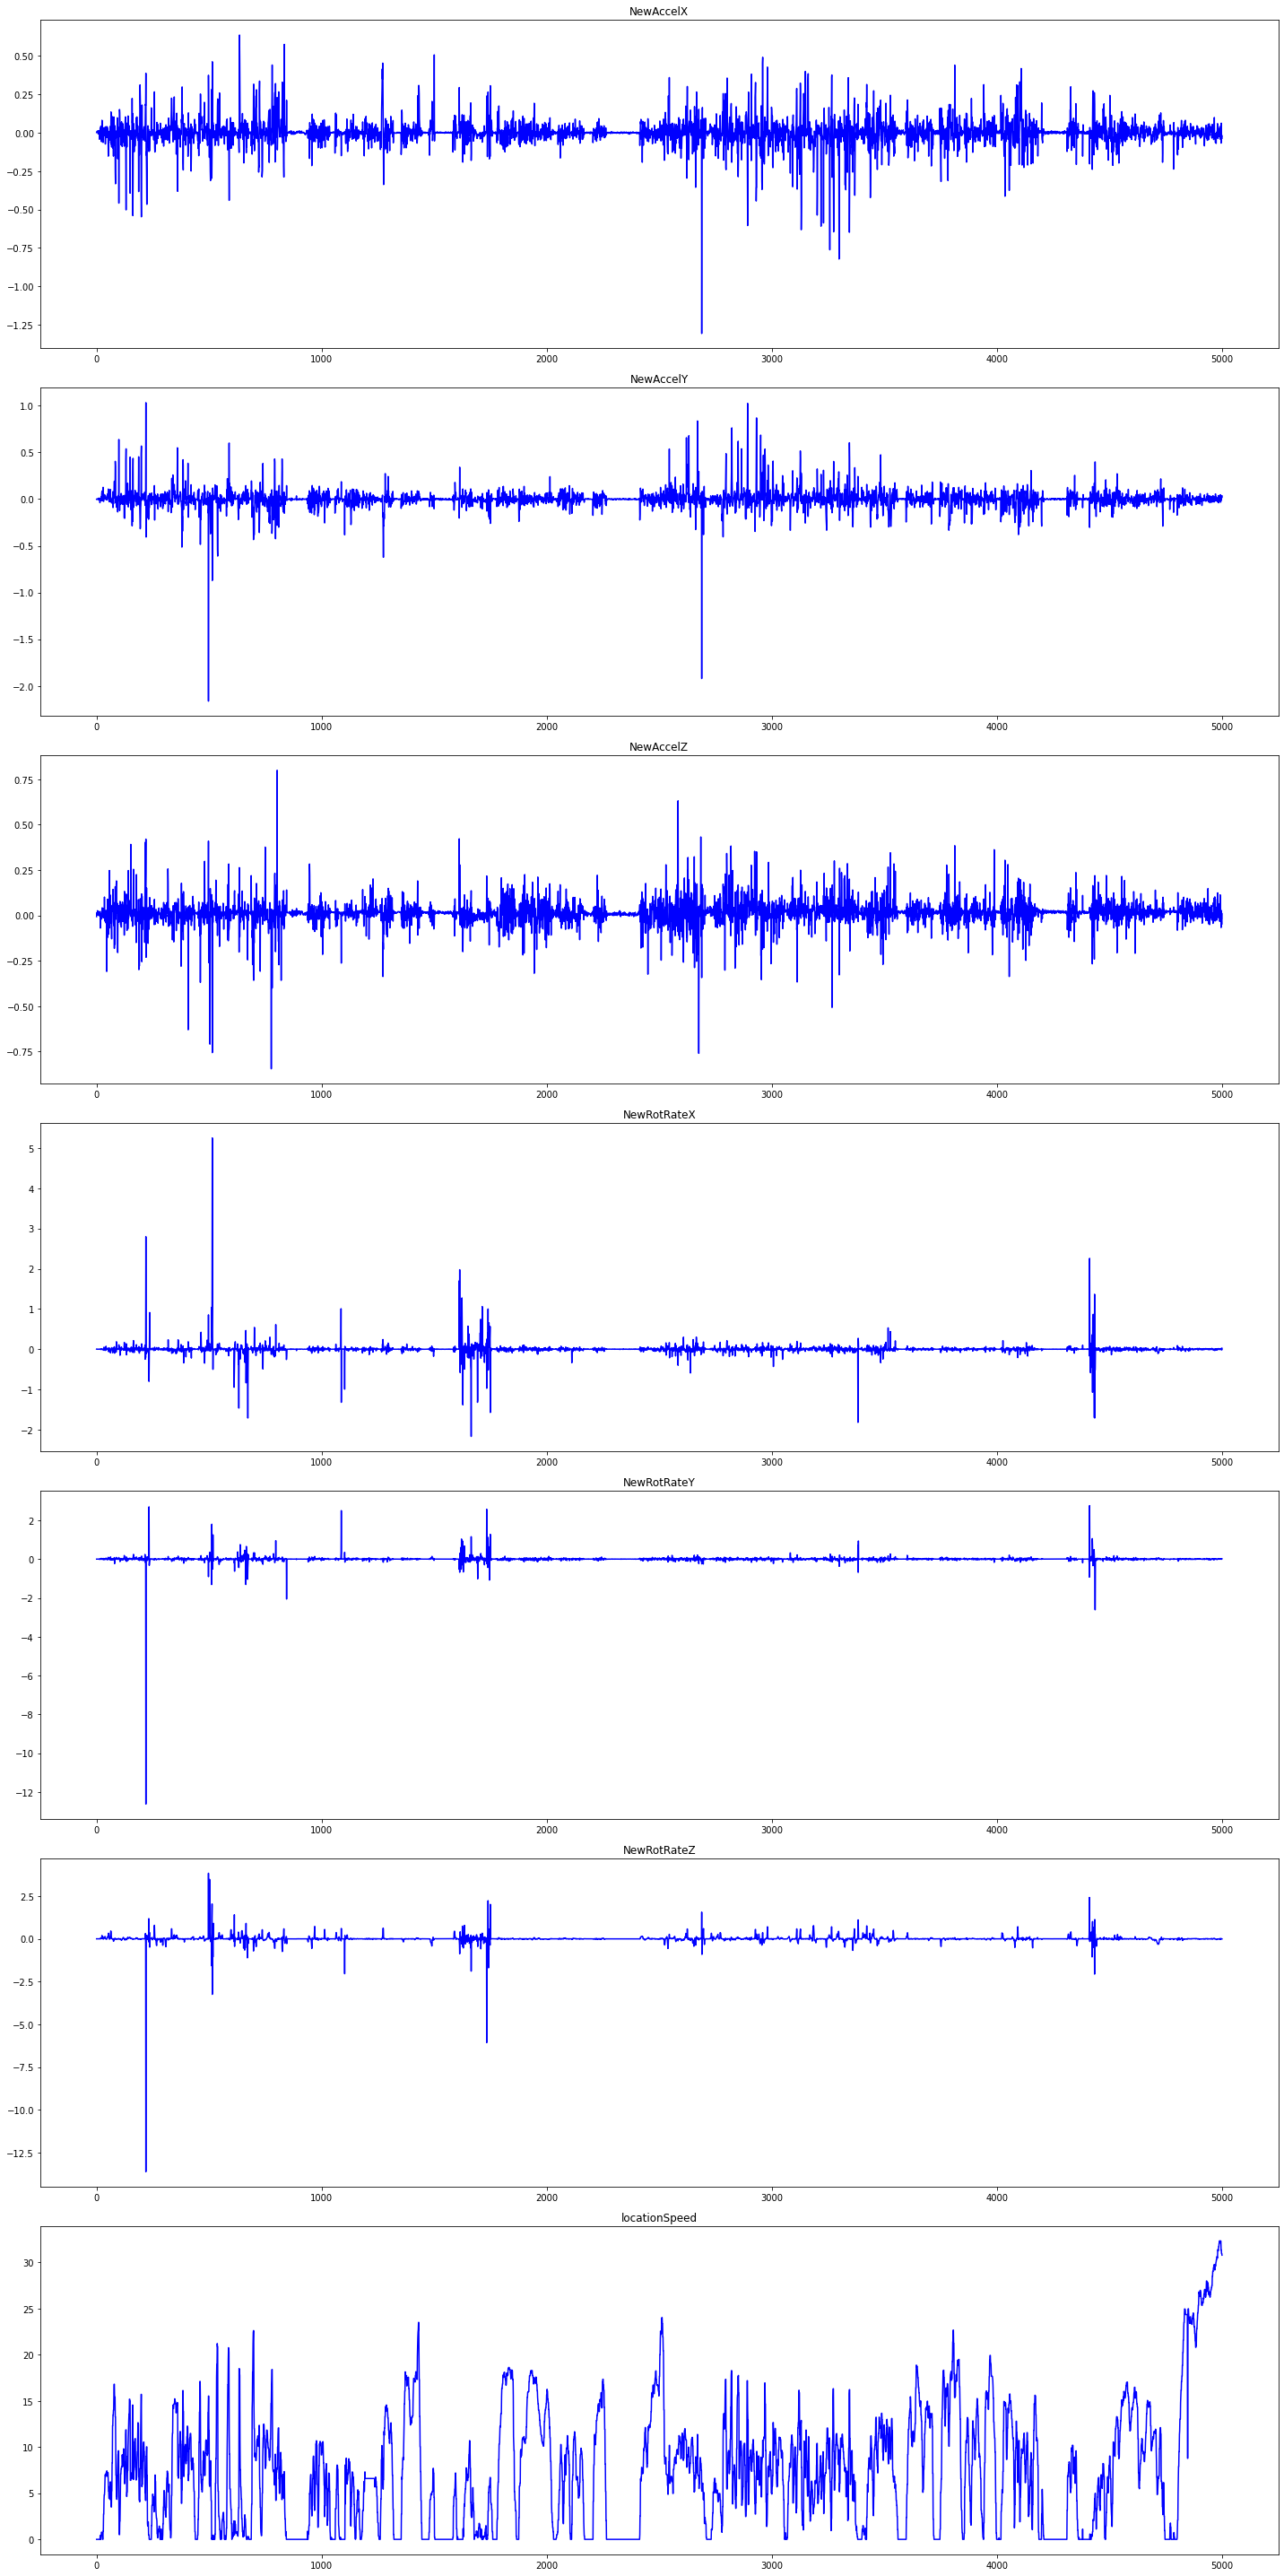

In [5]:
fig, axs = plt.subplots(7, 1, figsize=(20,40))
axs = axs.ravel()


def isof_plot(start,end):
    for i in range(7):
        axs[i].plot(df.iloc[start:end].index, df.iloc[start:end, i], color='blue')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

isof_plot(0,5000)

## Outliers Detection Algorithms

Επιλέξαμε αλγοριθμους οι οποίοι θα έχουν διαφορετική προσέγγιση ο καθένας. Πιο συγκεκριμένα επιλέξαμε :



*   KNN - Distance Based
*   LOF (Local Outlier Factor) - Density Based
*   KMeans - Cluster Based
*   Isolation Forest - Tree Based
*   AutoEncoders - Reconstruct Time Series
*   LSTM - Reconstruct Time Series with time Dependecies

Σε κάθε αλγόριθμο έχουμε 2 βασικά κριτήρια :



*   Να βρίσκουν (περίπου) τον ίδιο αριθμό outliers με τους άλλους αλγοριθμους
*   Να ικανοποιούν σε έναν βαθμό οπτικά. Δηλαδή τα σημεία που εντοπίζουν να έχουν μια μορφής ιδιαιτερότητα ακόμα και σε ένα μη εκπαιδευμένο μάτι , δηλαδή ενός μη ειδικού, όπως είναι ο συγγραφέας της συγκεκριμένης εργασίας.




In [6]:
outlier_contamination = 0.12 

### KNN

Στο σημείο αυτό θα αναφέρουμε τους λόγους που επιλέξαμε τις βασικές υπερπαράμετρους του αλγορίθμου. Αρχικά διαλέξαμε ένα σχετικά μικρό αριθμό από k γείτονες καθώς δεν επιθυμούμε ένα εν δυνάμει outlier να βρει έναν γείτονα αρκετά κοντά του. Έχοντας σαν βάση αυτό, δοκιμάσαμε διάφορα outlier distances ώστε να πάρουμε εν τέλη τον αριθμό από outliers που στοχεύουμε

In [7]:
from sklearn.neighbors import NearestNeighbors
outlier['knn']=1
outlier=pd.DataFrame(outlier.drop(columns=['NewAccelX','NewAccelY','NewAccelZ','NewRotRateX','NewRotRateY','NewRotRateZ','locationSpeed']))

In [8]:
neighbors=6
outlier_distance=0.1

In [9]:
knn = NearestNeighbors(n_neighbors = neighbors)
knn.fit(df)
distances, indexes = knn.kneighbors(df)

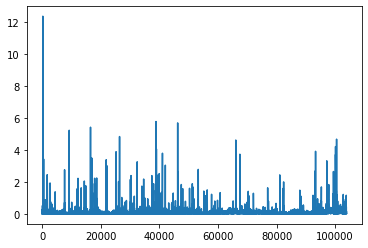

In [10]:
plt.plot(distances.mean(axis =1))

In [11]:
outlier_index_knn = np.where(distances.mean(axis = 1) > outlier_distance)
outlier.iloc[outlier_index_knn] = -1

In [12]:
frequency_knn = outlier['knn'].value_counts()
print(frequency_knn)


 1    91336
-1    12555
Name: knn, dtype: int64


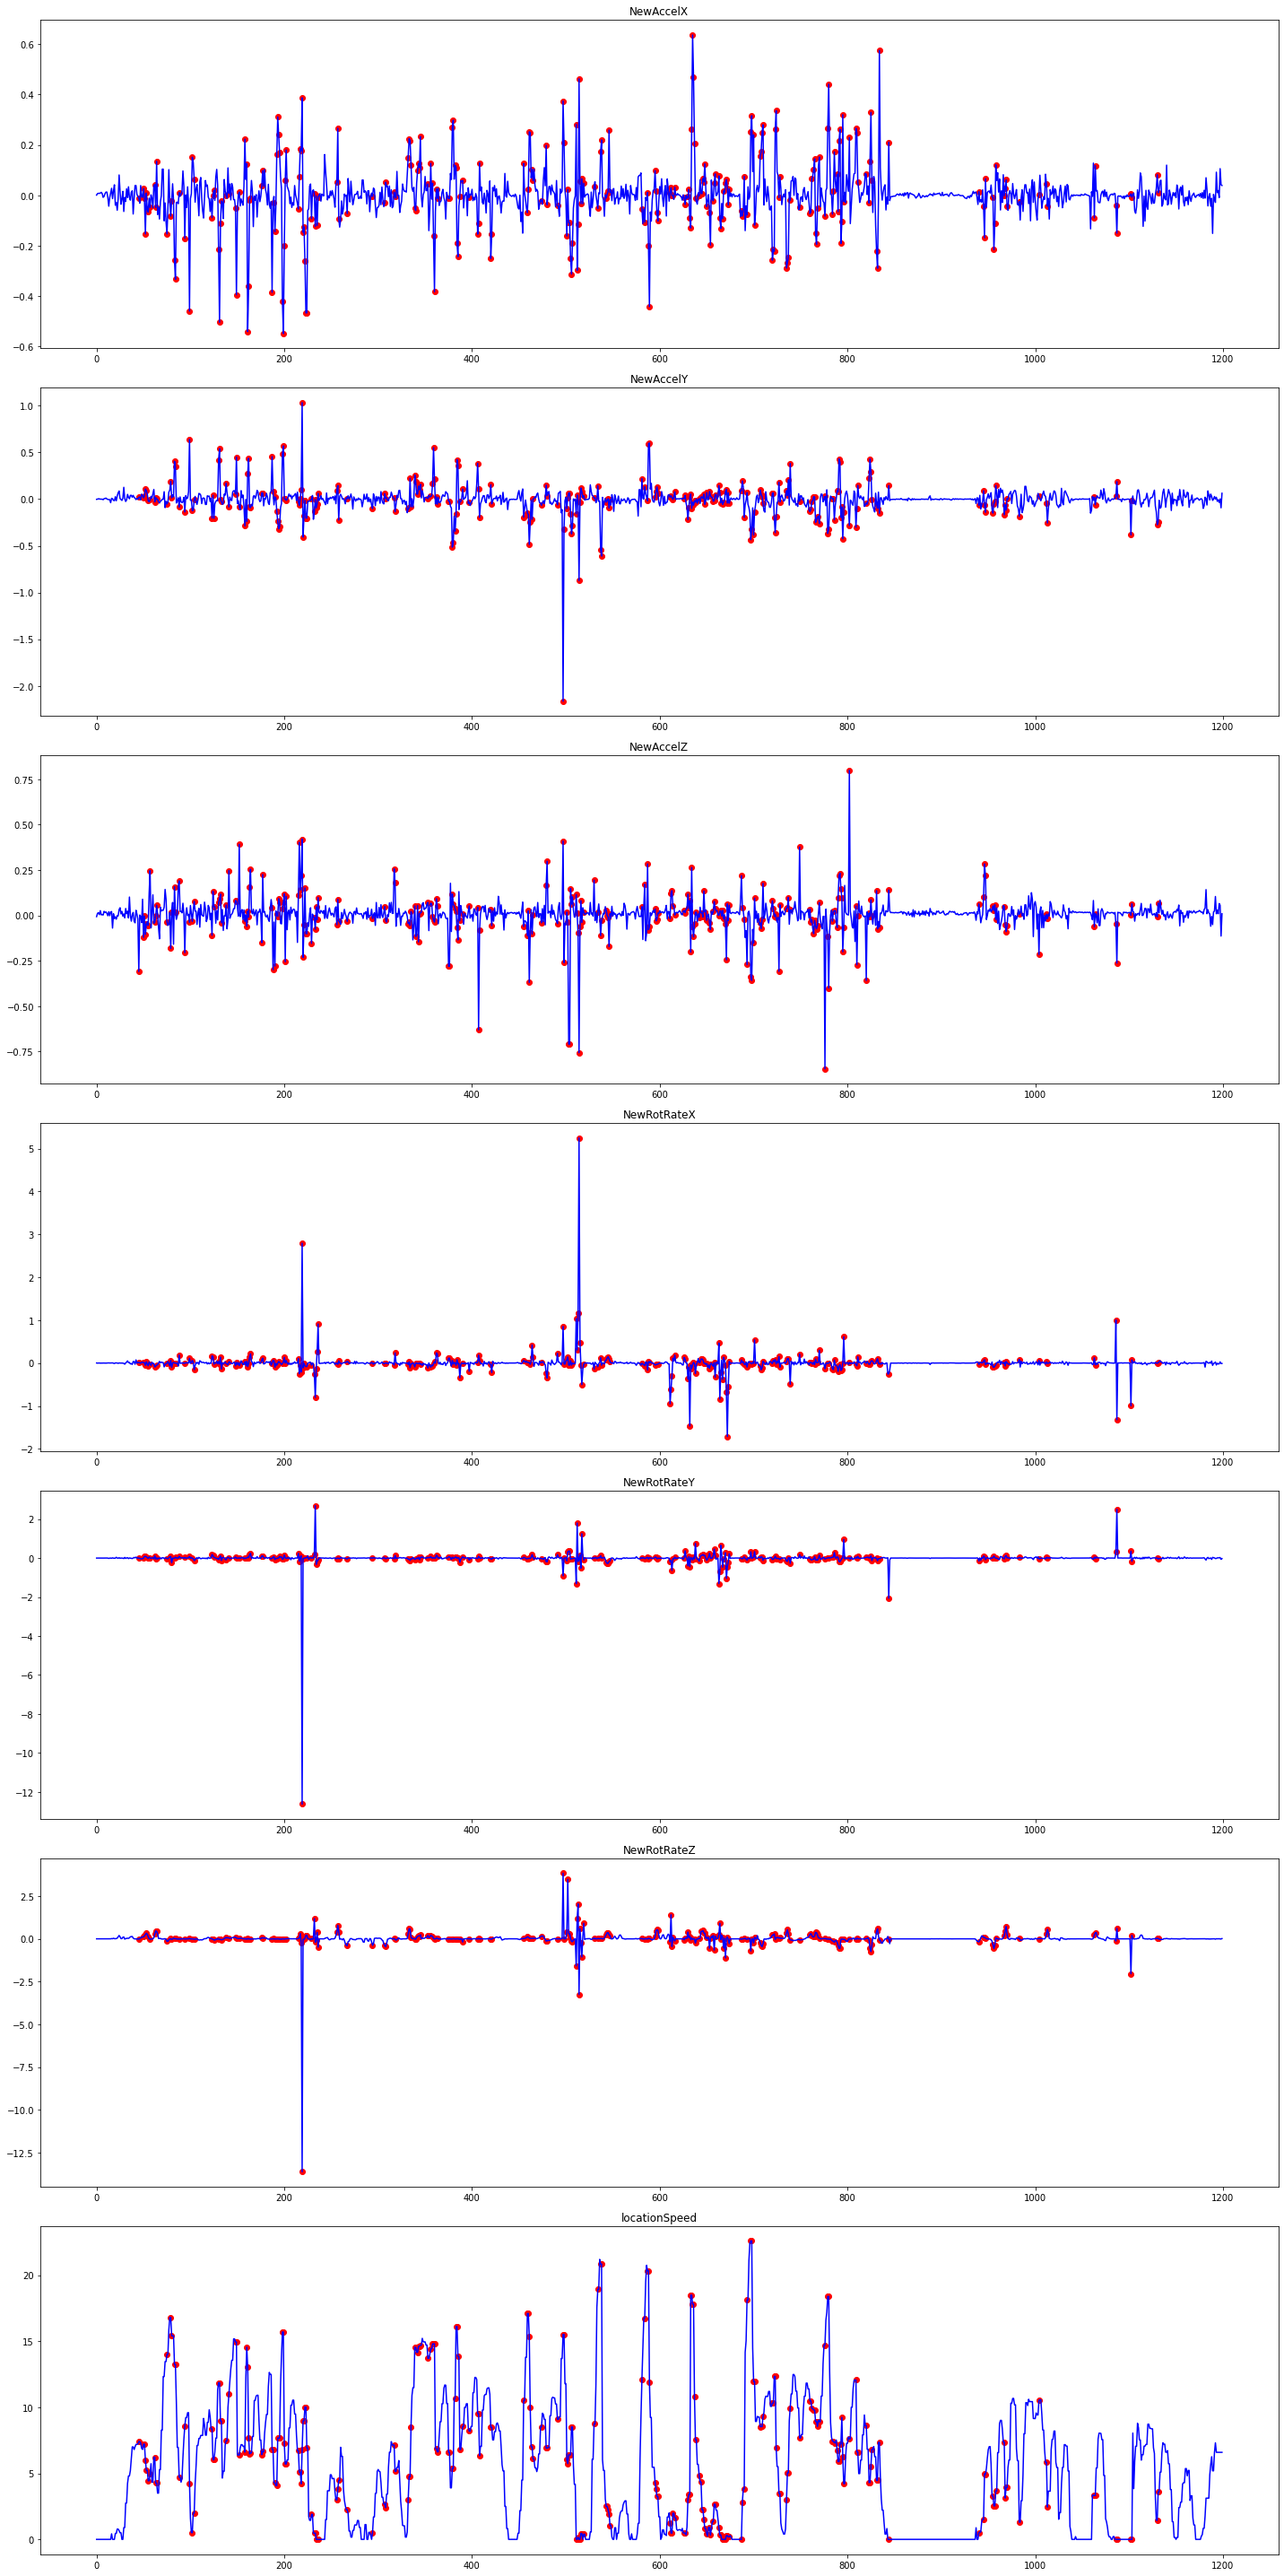

In [13]:
def knn_plot(start1,end1):
    
    absolute_val_array = np.abs(outlier_index_knn[0] - start1)
    start2 = absolute_val_array.argmin()
    
    absolute_val_array = np.abs(outlier_index_knn[0] - end1)
    end2 = absolute_val_array.argmin()
    
    fig, axs = plt.subplots(7, 1, figsize=(20,40))
    axs = axs.ravel()
    
    for i in range(7):
        axs[i].plot(df.iloc[start1:end1].index, df.iloc[start1:end1, i], color='blue', label = 'Normal')
        axs[i].scatter(outlier_index_knn[0][start2:end2], df.iloc[outlier_index_knn[0][start2:end2],i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

knn_plot(0,1200)

### LOF

Ο Local OutlierFactor μας δίνει την δυνατότητα να επιλέξουμε το πλήθος των outliers, συνεπώς δεν χρειάζεται να κάνουμε κάποιο παραπάνω έλεγχο για το κριτήριο αυτό που έχουμε θέσει. Το μόνο που μένει είναι το lof_neighbors, το οποίο κατα αντιστοιχεία είναι το k-neighbors. Αρχικά το θέσαμε στην ίδια τιμή με τον KNN , στη συνέχεια όμως μεγαλώσαμε την τιμή του και παρατηρήσαμε ελαφρώς καλύτερα αποτελέσματα.

In [14]:
from sklearn.neighbors import LocalOutlierFactor

lof_neighbors = 10
lof_cont = outlier_contamination
lof = LocalOutlierFactor(n_neighbors=lof_neighbors, contamination=lof_cont)

In [15]:
outlier["lof"] = lof.fit_predict(df)

In [16]:
frequency = outlier['lof'].value_counts()
print(frequency)

 1    91424
-1    12467
Name: lof, dtype: int64


In [17]:
outlier_index_lof=outlier[outlier["lof"]==-1].index

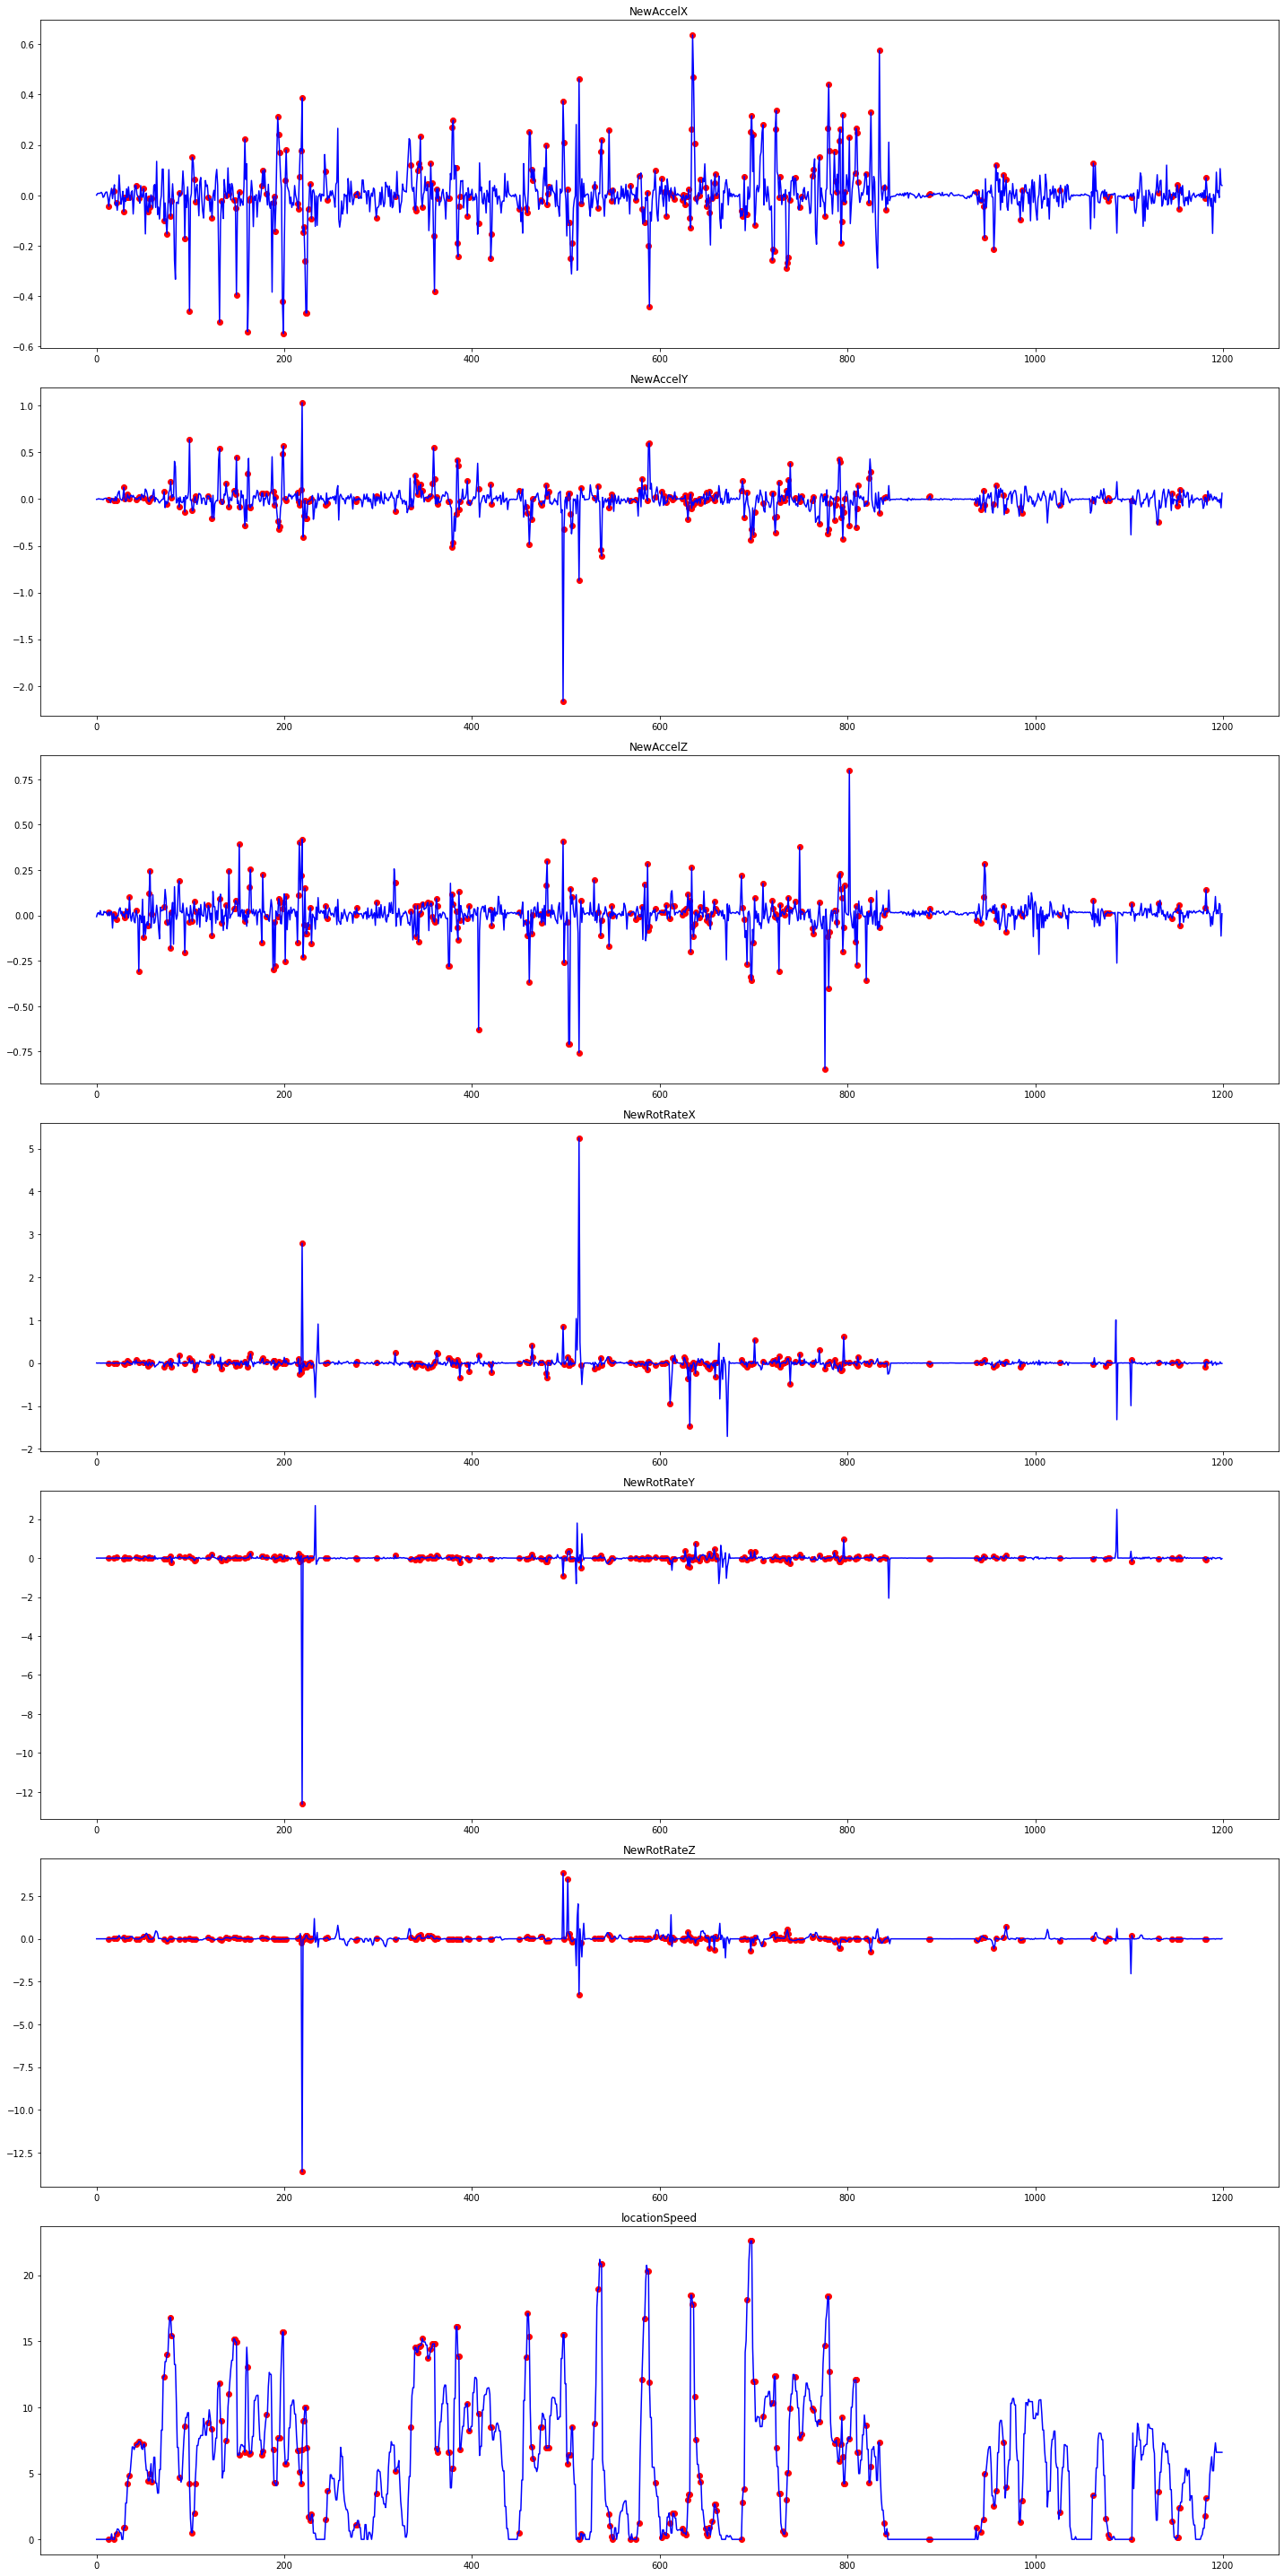

In [19]:
def lof_plot(start1,end1):
    
    absolute_val_array = np.abs(outlier_index_lof - start1)
    start2 = absolute_val_array.argmin()
    
    absolute_val_array = np.abs(outlier_index_lof - end1)
    end2 = absolute_val_array.argmin()
    
    fig, axs = plt.subplots(7, 1, figsize=(20,40))
    axs = axs.ravel()
    
    for i in range(7):
        axs[i].plot(df.iloc[start1:end1].index, df.iloc[start1:end1, i], color='blue', label = 'Normal')
        axs[i].scatter(outlier_index_lof[start2:end2], df.iloc[outlier_index_lof[start2:end2],i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

lof_plot(0,1200)

### Isolation Forest

Την βοηθητική outlier_contamination που την έχουμε σαν παράμετρο στο συγκεκριμένο πρόβλημα , παρέχει και ο αλγόριθμος Isolation Forest.

In [20]:
from sklearn.ensemble import IsolationForest

iso_estimators = 200
iso_cont = outlier_contamination

In [21]:
isof = IsolationForest(n_estimators = iso_estimators, contamination = iso_cont, warm_start = True)
outlier["isof"] = isof.fit_predict(df)

In [22]:
frequency = outlier['isof'].value_counts()
print(frequency)

 1    91424
-1    12467
Name: isof, dtype: int64


In [23]:
outlier_index_isof=outlier[outlier["isof"]==-1].index

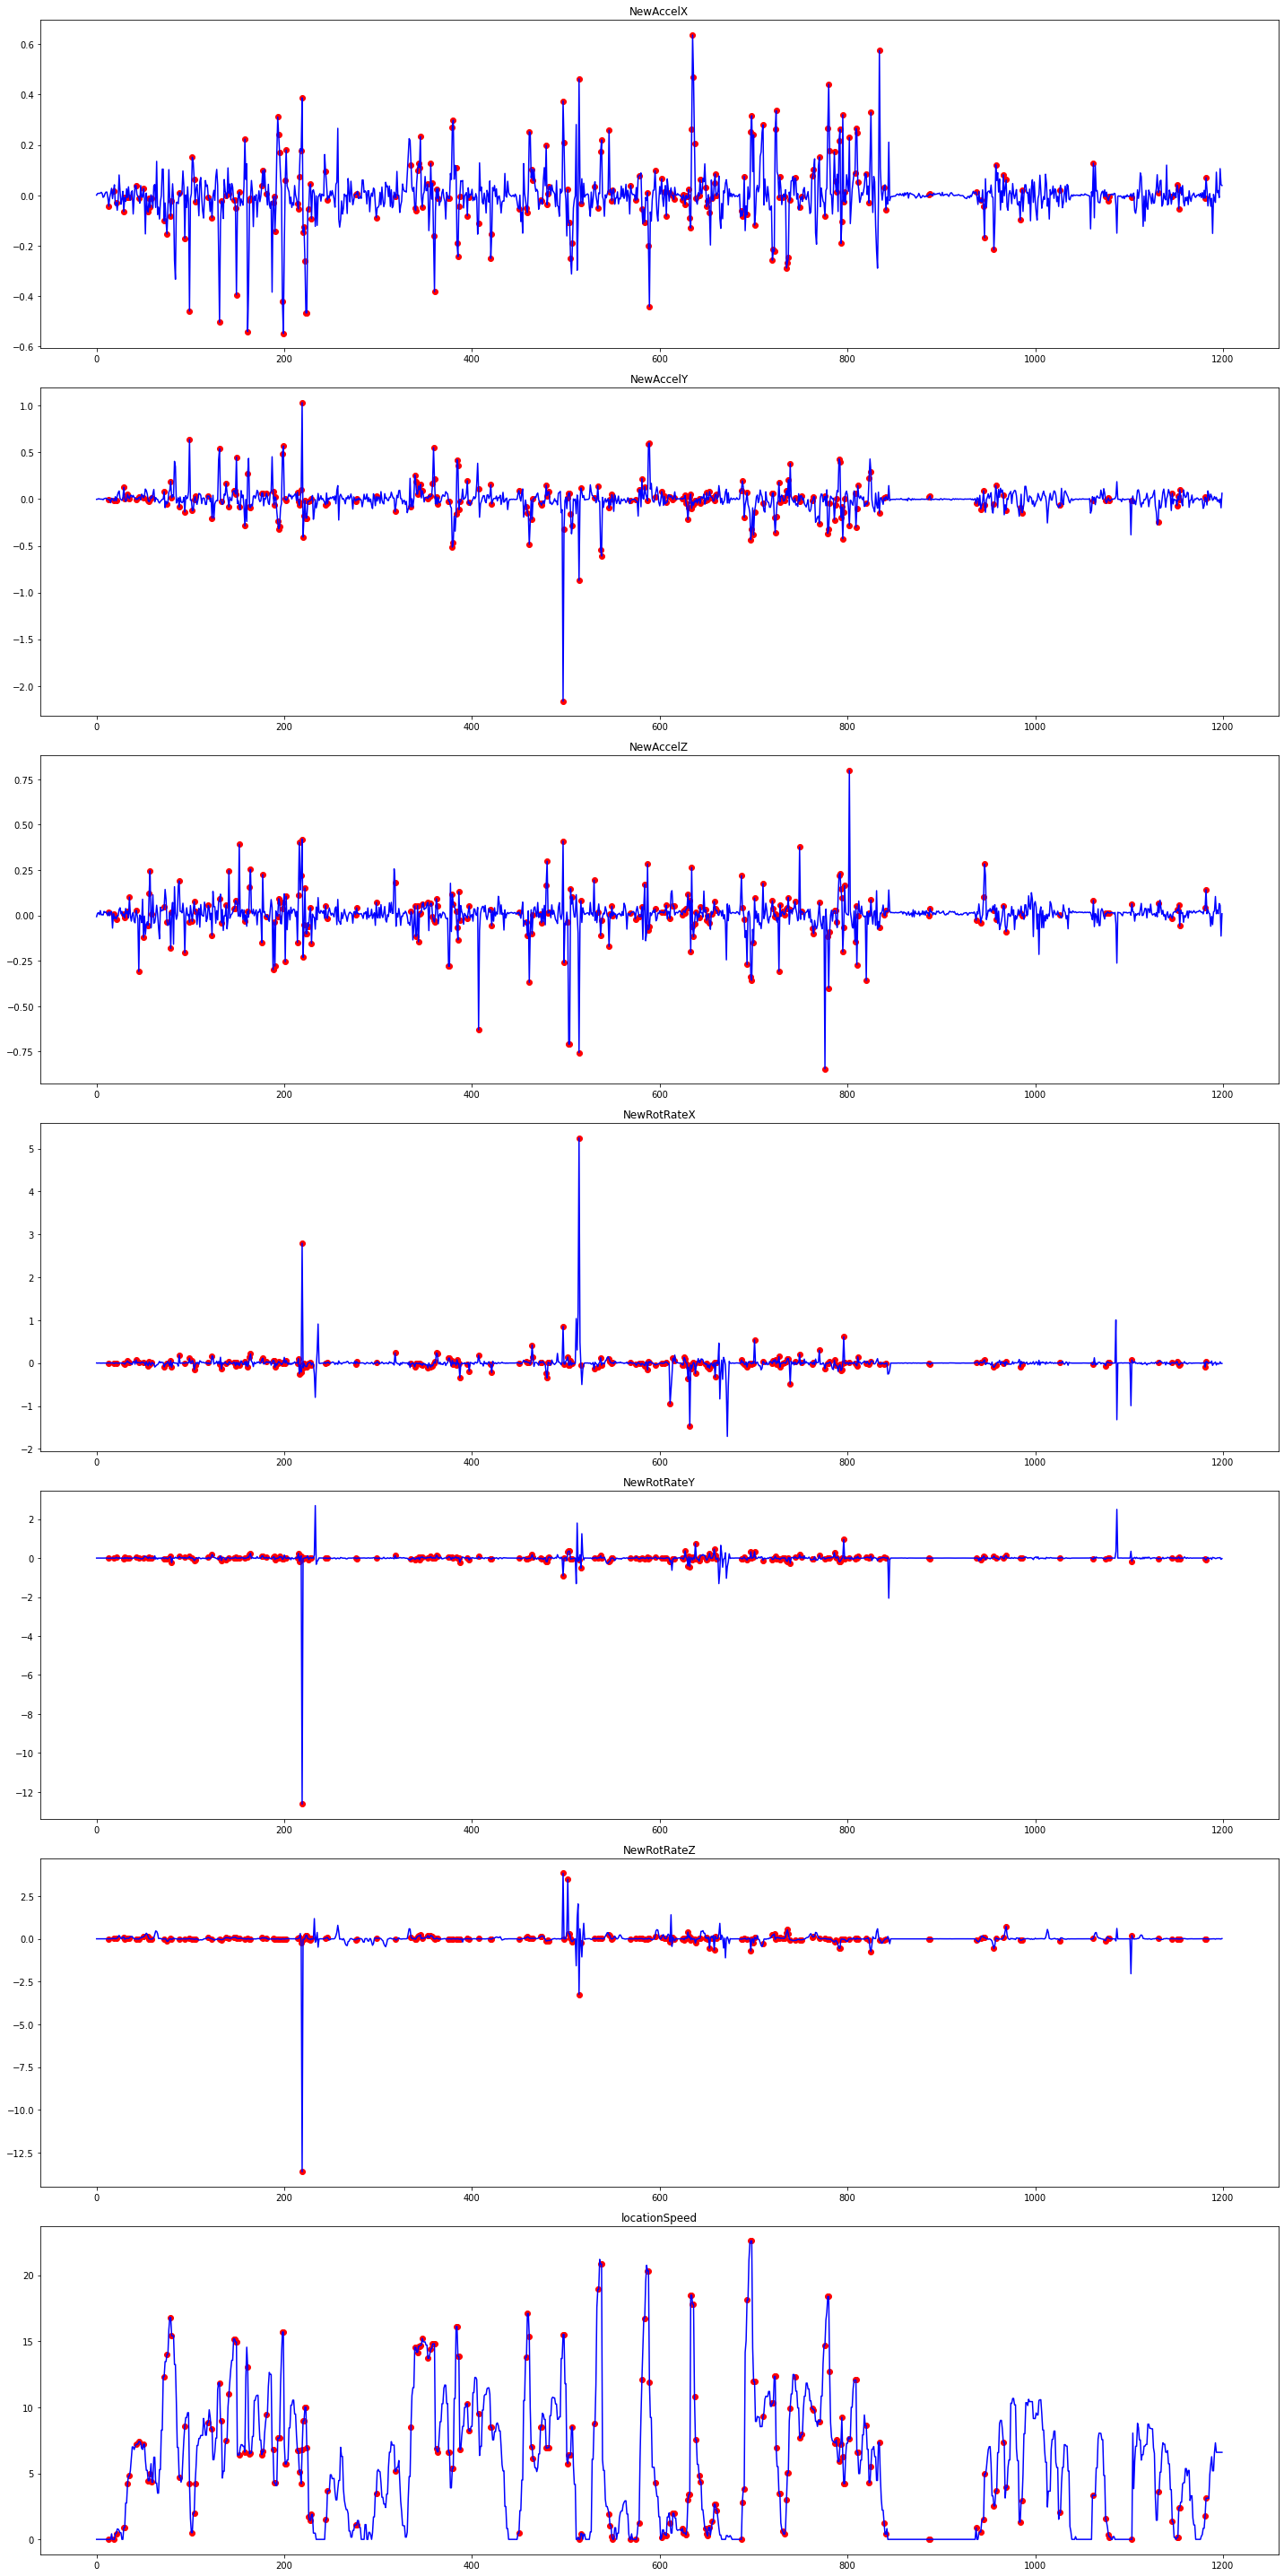

In [24]:
def isof_plot(start1,end1):
    
    absolute_val_array = np.abs(outlier_index_isof - start1)
    start2 = absolute_val_array.argmin()
    
    absolute_val_array = np.abs(outlier_index_isof - end1)
    end2 = absolute_val_array.argmin()
    
    fig, axs = plt.subplots(7, 1, figsize=(20,40))
    axs = axs.ravel()
    
    for i in range(7):
        axs[i].plot(df.iloc[start1:end1].index, df.iloc[start1:end1, i], color='blue', label = 'Normal')
        axs[i].scatter(outlier_index_isof[start2:end2], df.iloc[outlier_index_isof[start2:end2],i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

lof_plot(0,1200)

### KMeans

Ο KMeans είναι ένας αλγόριθμος clustering, συνεπώς θα συσταδοποιήσει τα δεδομένα μας και ύστερα εμείς με κατάλληλη επεξεργιασία θα διαλέξουμε τα outliers. Αρχικά επιλέξαμε 5 clusters και στη συνέχεια υπολογίζουμε τις αποστάσεις των σημείων από τα κέντρα τους και τα ταξινομούμε. Τέλος με την κατάλληλη παράμετρο επιλέγουμε το ποσοστό που θέλουμε

In [25]:
from sklearn.cluster import KMeans

kmeans_cont = outlier_contamination

In [26]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)
labels = kmeans.predict(df)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

distance = getDistanceByPoint(df, kmeans)

number_of_outliers = int(kmeans_cont*len(distance))

threshold = distance.nlargest(number_of_outliers).min()

outlier['kmeans'] = -1*(distance >= threshold).astype(int)

In [27]:
outlier.loc[outlier.kmeans == 0, 'kmeans'] = 1

In [28]:
frequency = outlier['kmeans'].value_counts()
print(frequency)

 1    91425
-1    12466
Name: kmeans, dtype: int64


In [29]:
outlier_index_kmeans=outlier[outlier["kmeans"]==-1].index

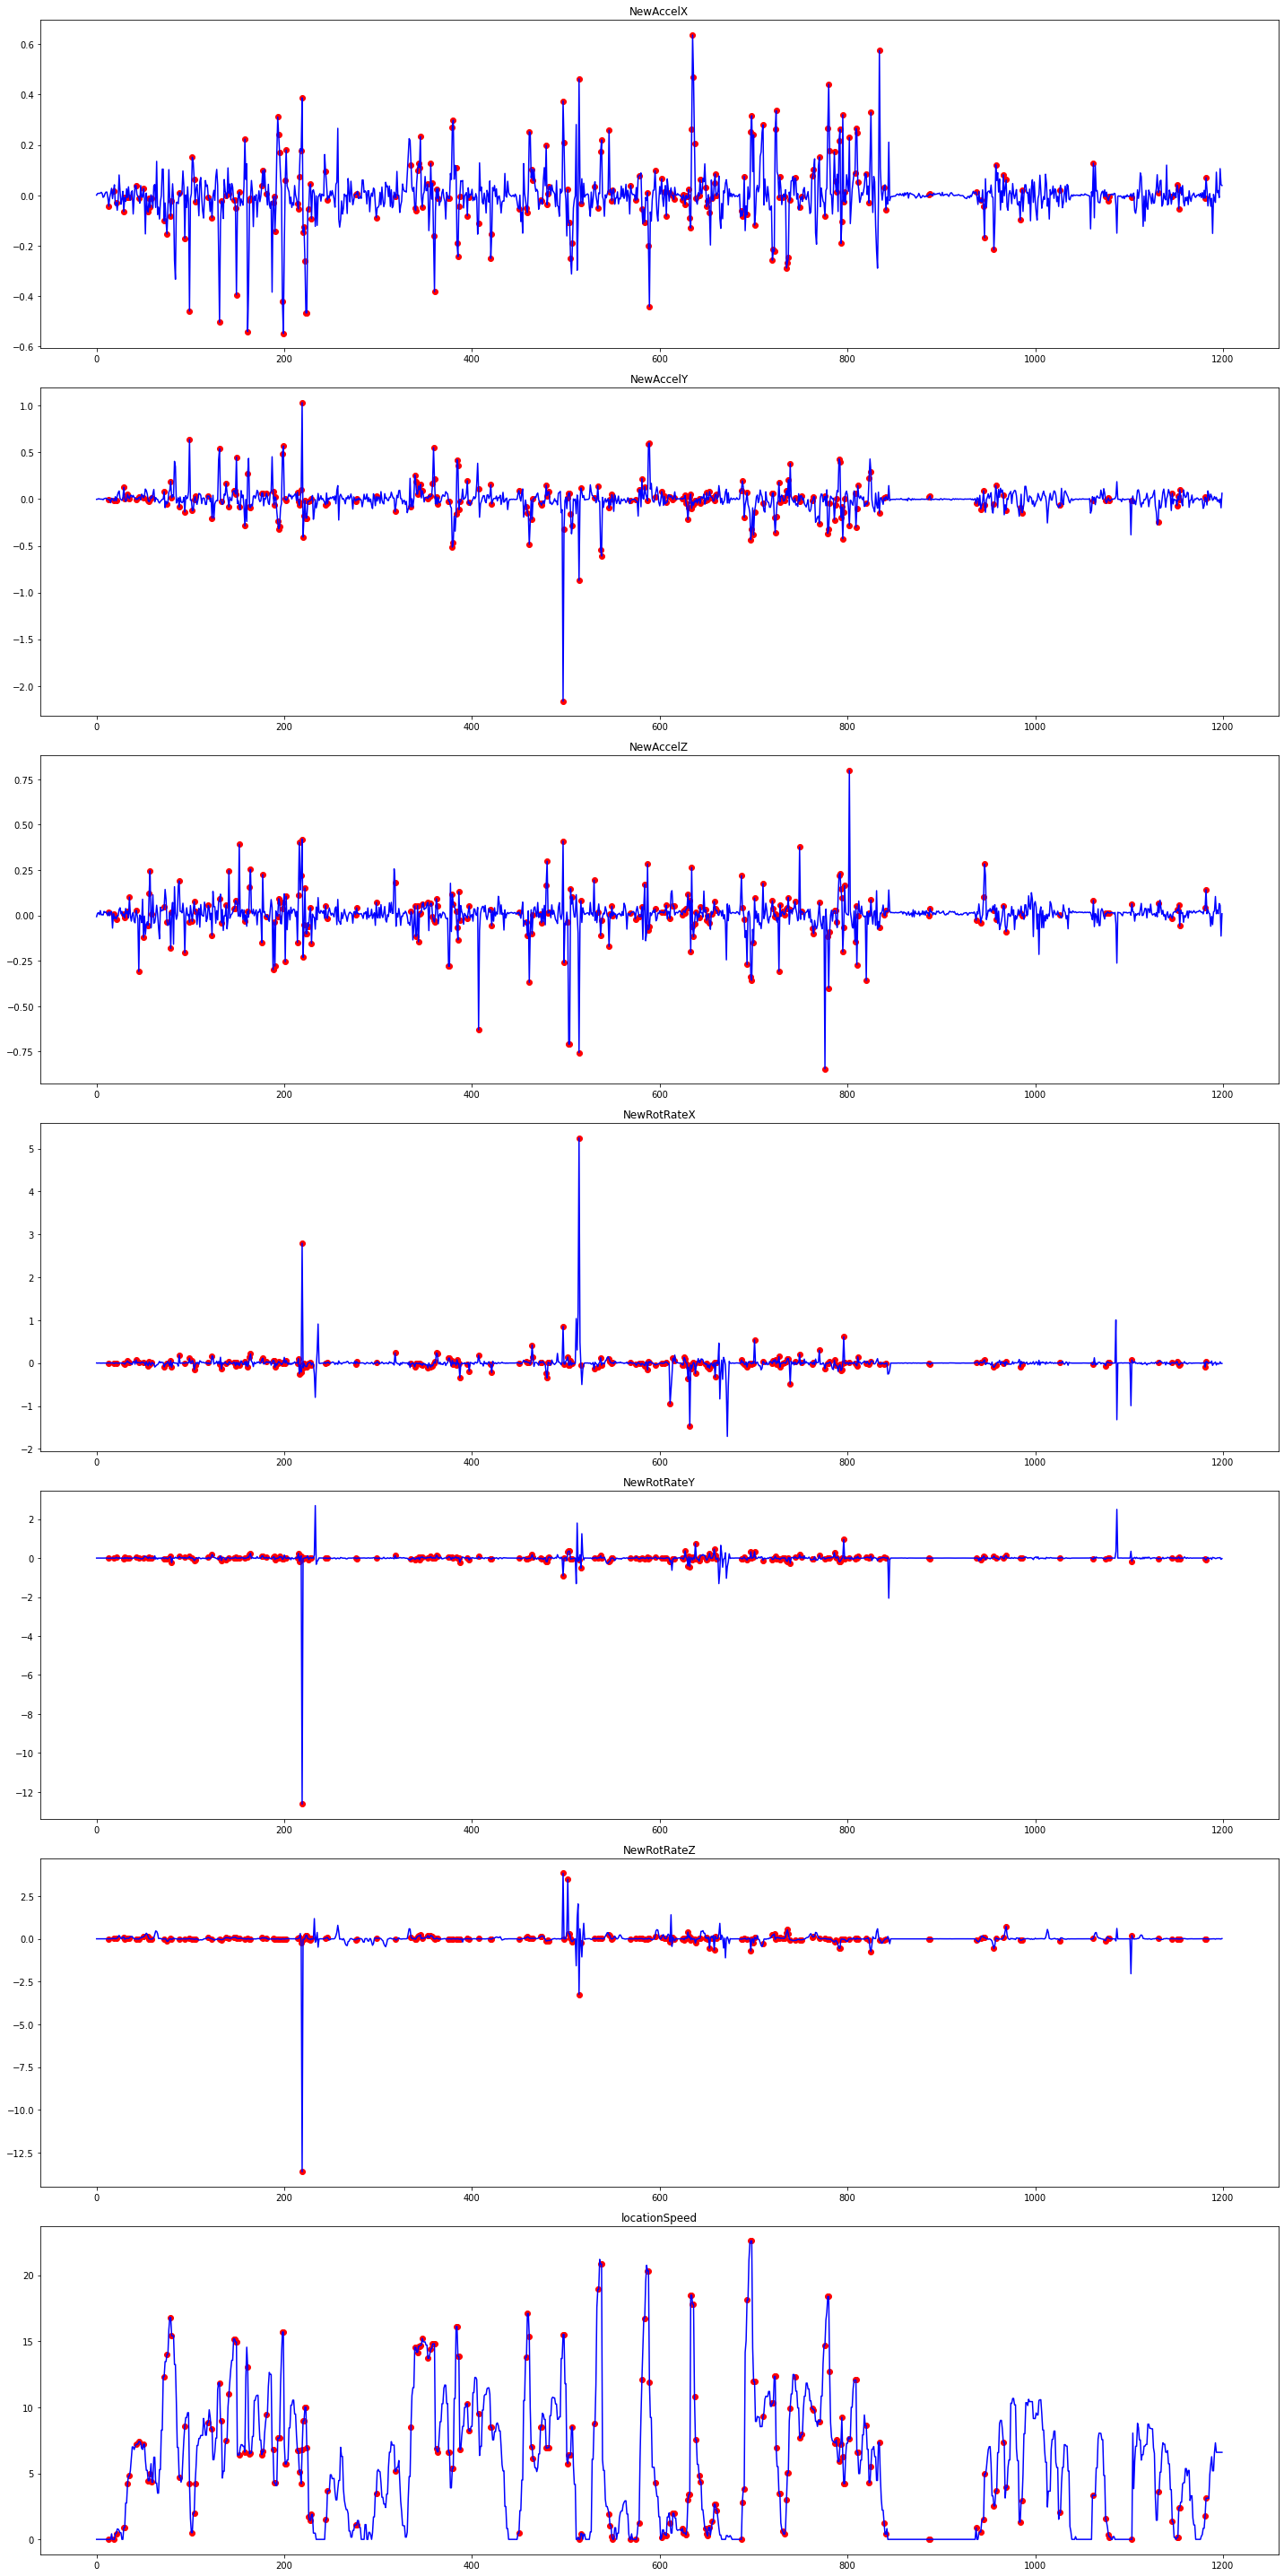

In [30]:
def kmeans_plot(start1,end1):
    
    absolute_val_array = np.abs(outlier_index_kmeans - start1)
    start2 = absolute_val_array.argmin()
    
    absolute_val_array = np.abs(outlier_index_kmeans - end1)
    end2 = absolute_val_array.argmin()
    
    fig, axs = plt.subplots(7, 1, figsize=(20,40))
    axs = axs.ravel()
    
    for i in range(7):
        axs[i].plot(df.iloc[start1:end1].index, df.iloc[start1:end1, i], color='blue', label = 'Normal')
        axs[i].scatter(outlier_index_kmeans[start2:end2], df.iloc[outlier_index_kmeans[start2:end2],i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

lof_plot(0,1200)

### Autoencoders

Η φιλοσοφία του Autoencoder στον τομέα της ανίχνευσης outlier, είναι ότι προσπαθεί να κωδικοποιοήσει τα δεδομένα , δηλαδή να εξάγει latent features και κρυφά μοτίβα και στη συνέχεια έχοντας αυτά σας είσοδο να τα αναπαράξει. Μια ακόμα διαισθητική ερμηνεία είναι ότι προσπαθεί να εντοπίζει την συνάρτηση κατανομής των δεδομένων και να την χρησιμοποιήσει για να αναπαράξει τα δεδομένα.

Πλεόν έχοντας συμπιέσει και αποσυμπιέσει τα δεδεμένα μας υπολογίζουμε το anomaly score, δηλαδή το error μεταξύ των original και reconstructed data και επιλέγουμε το cut off σημείο.

In [33]:
!pip install pyod
from pyod.models.auto_encoder import AutoEncoder
AE_cont= outlier_contamination

In [34]:
AE = AutoEncoder(hidden_neurons =[7, 10, 2, 10, 7],epochs=10,contamination=AE_cont)
AE.fit(df)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 7)                 56        
_________________________________________________________________
dropout_7 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 56        
_________________________________________________________________
dropout_8 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 56        
_________________________________________________________________
dropout_9 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

AutoEncoder(batch_size=32, contamination=0.12, dropout_rate=0.2, epochs=10,
      hidden_activation='relu', hidden_neurons=[7, 10, 2, 10, 7],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f1e1ad90560>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

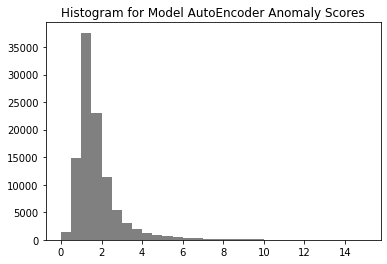

In [36]:
# Get the outlier scores for the train data
train_scores = AE.decision_scores_  

plt.hist(train_scores, 30, range=[0,15], facecolor='gray', align='mid')
plt.title("Histogram for Model AutoEncoder Anomaly Scores")
plt.show()

In [41]:
outlier['AE score'] = train_scores
outlier['AE'] = np.where(outlier['AE score']<2.7, 1, -1)
outlier=pd.DataFrame(outlier.drop(columns=['AE score']))

In [44]:
frequency = outlier['AE'].value_counts()
print(frequency)

 1    90892
-1    12999
Name: AE, dtype: int64


In [45]:
outlier_index_AE=outlier[outlier["AE"]==-1].index

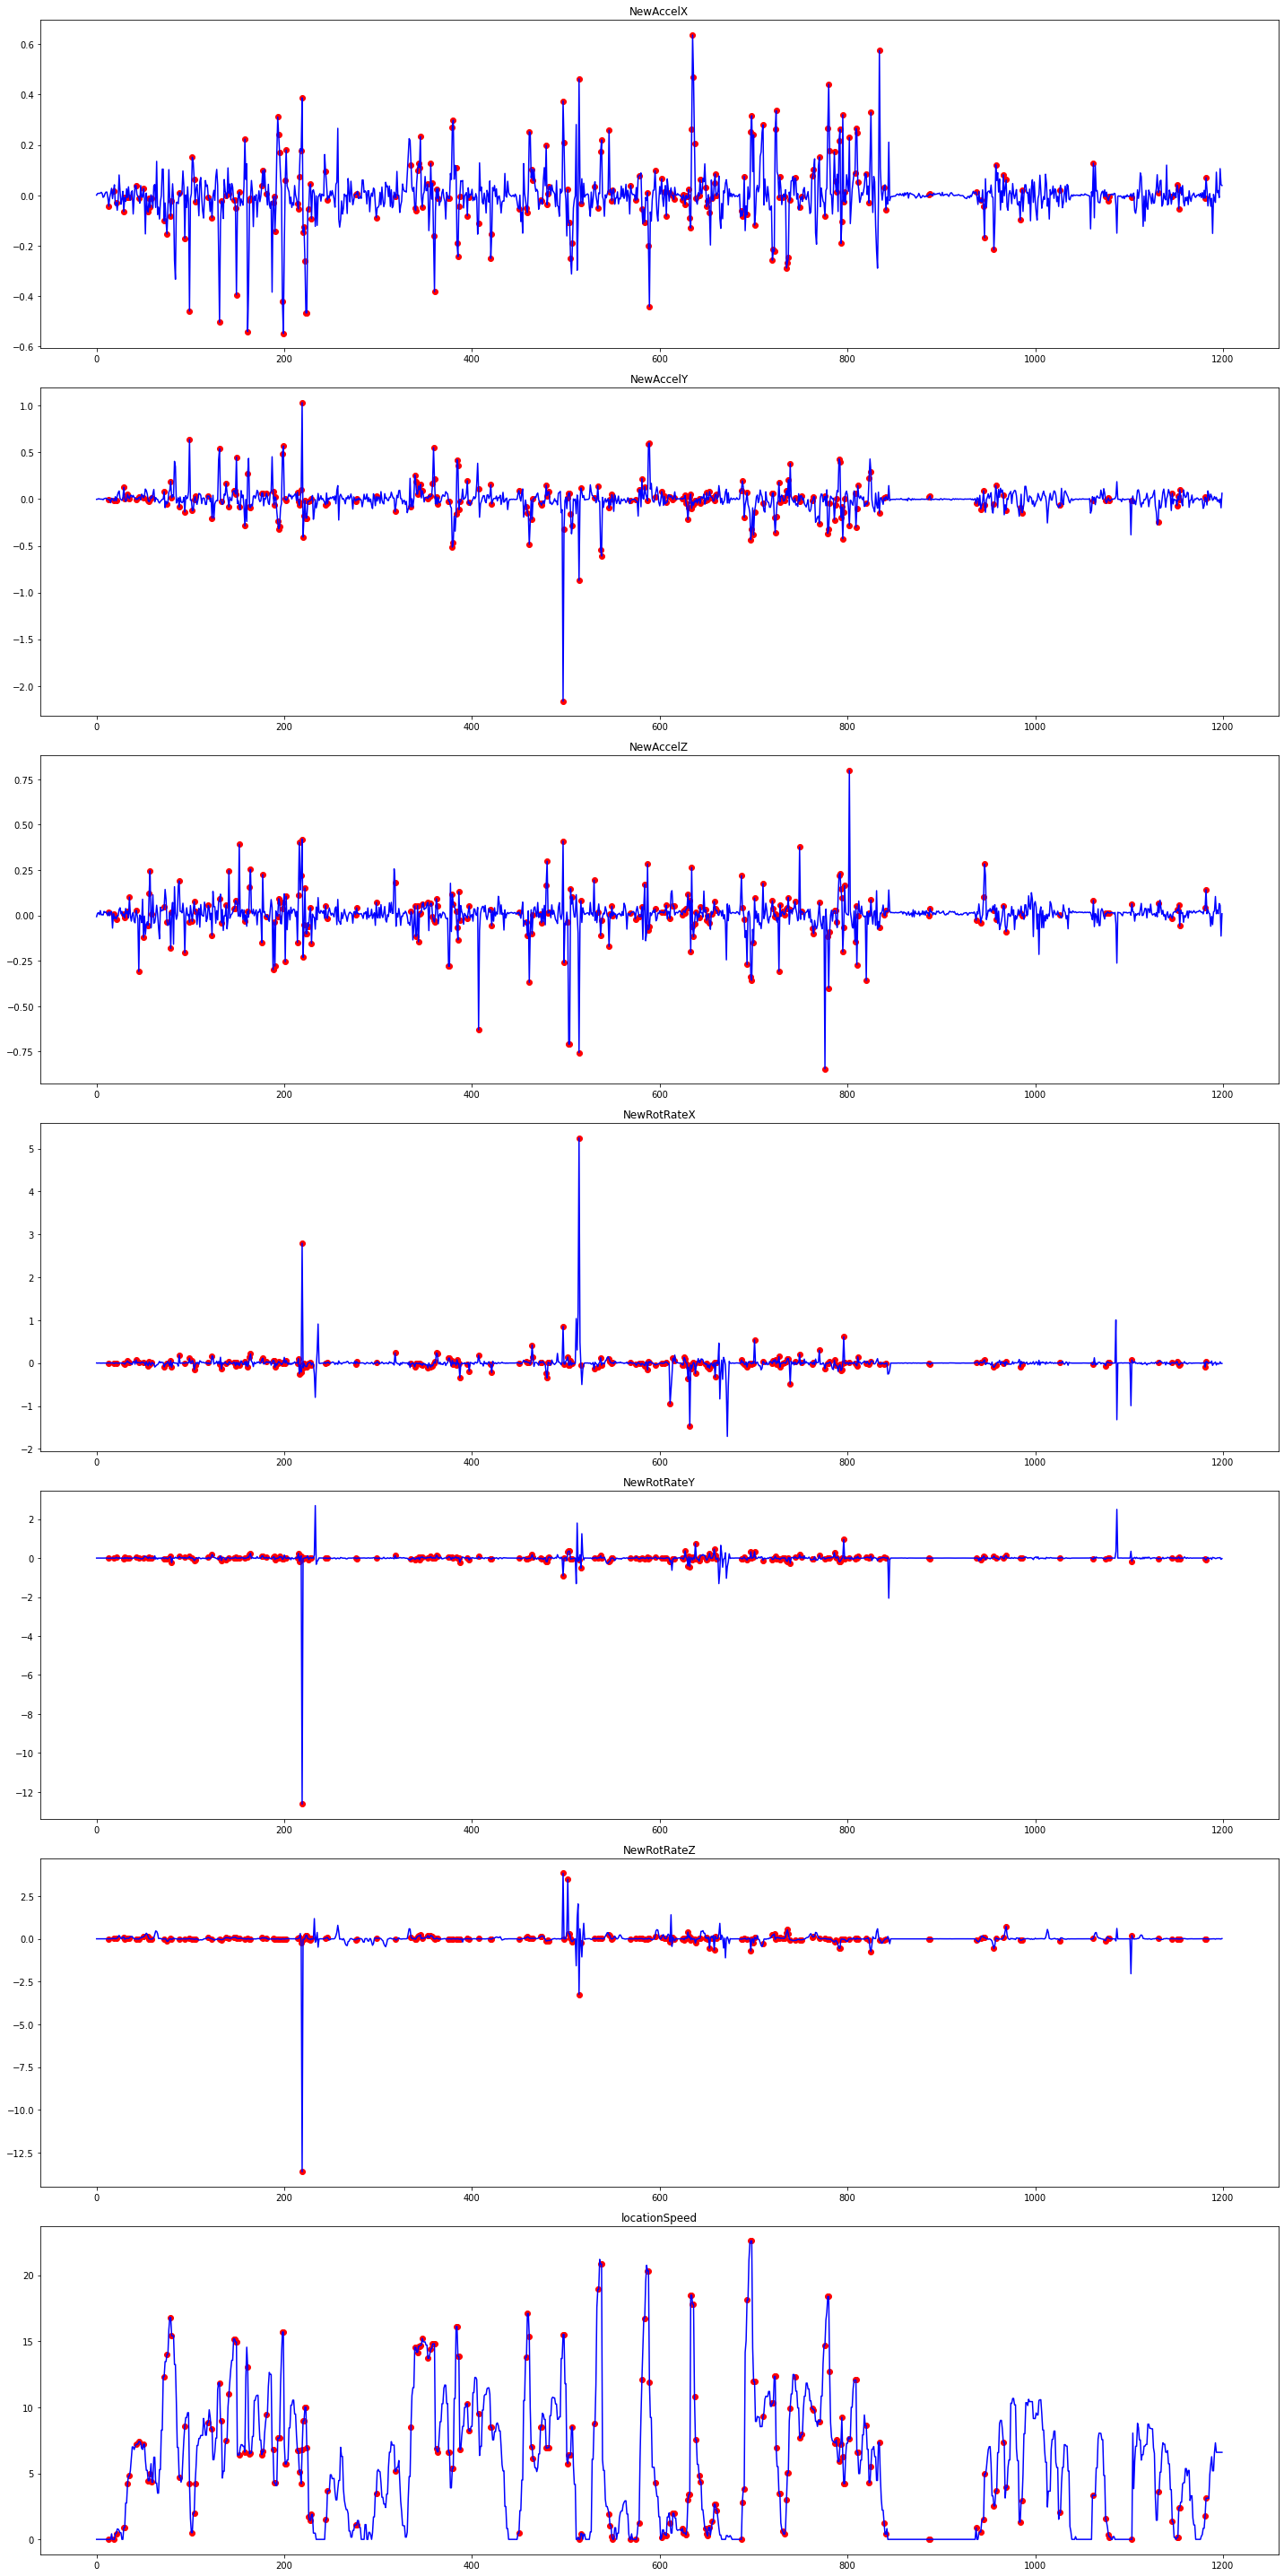

In [46]:
def AE_plot(start1,end1):
    
    absolute_val_array = np.abs(outlier_index_AE - start1)
    start2 = absolute_val_array.argmin()
    
    absolute_val_array = np.abs(outlier_index_AE - end1)
    end2 = absolute_val_array.argmin()
    
    fig, axs = plt.subplots(7, 1, figsize=(20,40))
    axs = axs.ravel()
    
    for i in range(7):
        axs[i].plot(df.iloc[start1:end1].index, df.iloc[start1:end1, i], color='blue', label = 'Normal')
        axs[i].scatter(outlier_index_AE[start2:end2], df.iloc[outlier_index_AE[start2:end2],i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

lof_plot(0,1200)

### LSTM 

Σαν τελευταίο κομμάτι του outlier detection κάνουμε εφαρμογή των LSTMs, με το εξής σκεπτικό :



*   Αρχικά, πρέπει να κάνουμε τα δεδομένα μας labeled. Αυτο γίνεται με το να θέτουμε σαν label των [0-29] στοιχείων το 30ο, έπειτα το label των [1-30] το 31 κτλπ. Επομένως γίνεται αυτή η επεξεργασία. Επιλέξαμε το window size να είναι 30 καθώς θεωρήσαμε ότι με βάση την περίοδο που υποθέσαμε οι 30 προηγούμενες δειγματοληψίες μπορούν να δώσουν πληρφορίες.
*   Στη συνεχεια εκπαιδεύουμε το μοντέλο μας και το βάζουμε να προβλέψει πάλι τα δεδομένα μας, δηλαδή έχουμε πάλι μια ανακατασκευή αλλά πλέον λαμβάνουμε υπόψιν και το παρελθόν, πχ είχαμε επιτάχυνση πριν.
*   Την παραπάνω διαδικασία την εκτελούμε 4 φορές. 1 φορά για κάθε feature ανεξάρτητα έχοντας εφαρμόσει min max scaling και 1 χώρις, 1 φορά για όλα τα featurs μαζί έχοντας εφαρμόσει min max scaling και 1 χωρίς.

ΠΡΟΣΟΧΗ ΜΗΝ ΕΚΤΕΛΕΣΤΕΙ Ο ΠΑΡΑΚΑΤΩ ΚΩΔΙΚΑΣ ΕΙΝΑΙ ΧΡΟΝΟΒΟΡΟΣ!!
ΕΧΕΙ ΕΚΤΕΛΕΣΤΕΙ ΗΔΗ ΚΑΙ ΕΧΟΥΝ ΑΠΟΘΗΚΕΥΤΕΙ ΤΑ ΑΠΟΤΕΛΕΣΜΑΤΑ ΤΟΥ



In [162]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout,LSTM,RepeatVector,TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [198]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [235]:
k=7

def split_min_max():

  X_train1=[]
  y_train1=[]
  sc1=[]

  for i in range(k):

    df_tonos=np.array(df.iloc[:, i])
    df_tonos=df_tonos.reshape(df_tonos.shape[0], 1)
    df_tonos=pd.DataFrame(df_tonos)
    '''
    sc = MinMaxScaler()
    df_tonos = pd.DataFrame(sc.fit_transform(df_tonos))
    sc1.append(sc)
    '''

    n_past = 30
    n_future = 1 
    n_features = 1
    X_train, y_train = split_series(df_tonos.values,n_past, n_future)

    X_train1.append(X_train.reshape((X_train.shape[0], X_train.shape[1],n_features)))
    y_train2 = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

    y_train1.append(y_train2[:, 0, :])
  return X_train1,y_train1 #,sc1

In [236]:
X_train,y_train=split_min_max() #,trans

In [237]:
def lstm_AE(X_train):
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 16, return_sequences = True))
    model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 8))
    model.add(Dropout(0.2))
# Adding the output layer
    model.add(Dense(units = 1))

# Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [238]:
predictions=[]
for i in range(k):

  model=lstm_AE(X_train[i])
  model.fit(X_train[i],y_train[i], epochs=10, verbose=1)
  pred=model.predict(X_train[i])
  #predictions.append(trans[i].inverse_transform(pred))
  predictions.append(pred)

Epoch 1/10
3246/3246 [==============================] - 33s 9ms/step - loss: 0.0034
Epoch 2/10
3246/3246 [==============================] - 29s 9ms/step - loss: 0.0031
Epoch 3/10
3246/3246 [==============================] - 29s 9ms/step - loss: 0.0032
Epoch 4/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.0031
Epoch 5/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.0031
Epoch 6/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.0031
Epoch 7/10
3246/3246 [==============================] - 29s 9ms/step - loss: 0.0031
Epoch 8/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.0032
Epoch 9/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.0032
Epoch 10/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.0031
Epoch 1/10
3246/3246 [==============================] - 34s 9ms/step - loss: 0.0037
Epoch 2/10
3246/3246 [==============================] - 28s 9ms/step - loss

In [239]:
preds=np.concatenate((predictions[0],predictions[1]),axis=1)
for i in range(k-2):
  preds=np.concatenate((preds,predictions[i+2]),axis=1)
preds=pd.DataFrame(preds)

In [240]:
preds

0         1         2         3         4         5         6
0      -0.009247  0.029443  0.010279 -0.001043  0.003147  0.083144  0.897815
1      -0.005584 -0.002141  0.007989 -0.001043  0.003147 -0.037278  1.335124
2      -0.005506 -0.002392  0.012390 -0.001043  0.003147  0.008487  3.301365
3      -0.001213 -0.000277  0.011047 -0.001043  0.003147  0.019108  4.317695
4      -0.003619  0.009953  0.012324 -0.001043  0.003147  0.025699  5.210645
...          ...       ...       ...       ...       ...       ...       ...
103856 -0.004505 -0.003099  0.000120 -0.001043  0.003147  0.001404  0.324018
103857 -0.003030 -0.000404 -0.002075 -0.001043  0.003147  0.006475  0.324018
103858 -0.004824 -0.009773 -0.003347 -0.001043  0.003147 -0.001072  0.324018
103859 -0.004536  0.002774 -0.000222 -0.001043  0.003147  0.002631  0.324018
103860 -0.001654 -0.002442  0.001207 -0.001043  0.003147  0.004364  0.324018

[103861 rows x 7 columns]

In [50]:
df_new=df[30:].reset_index(drop=True)

In [242]:
for i in range(k):
  print("Column ",i," MSE: ",mean_squared_error(df_new.iloc[:,i], preds.iloc[:,i]))

Column  0  MSE:  0.0031035832212191273
Column  1  MSE:  0.0033462535172754586
Column  2  MSE:  0.0037950483101413133
Column  3  MSE:  0.018144871826612525
Column  4  MSE:  0.01665506327719619
Column  5  MSE:  0.018379772928958486
Column  6  MSE:  1.0547886749442914


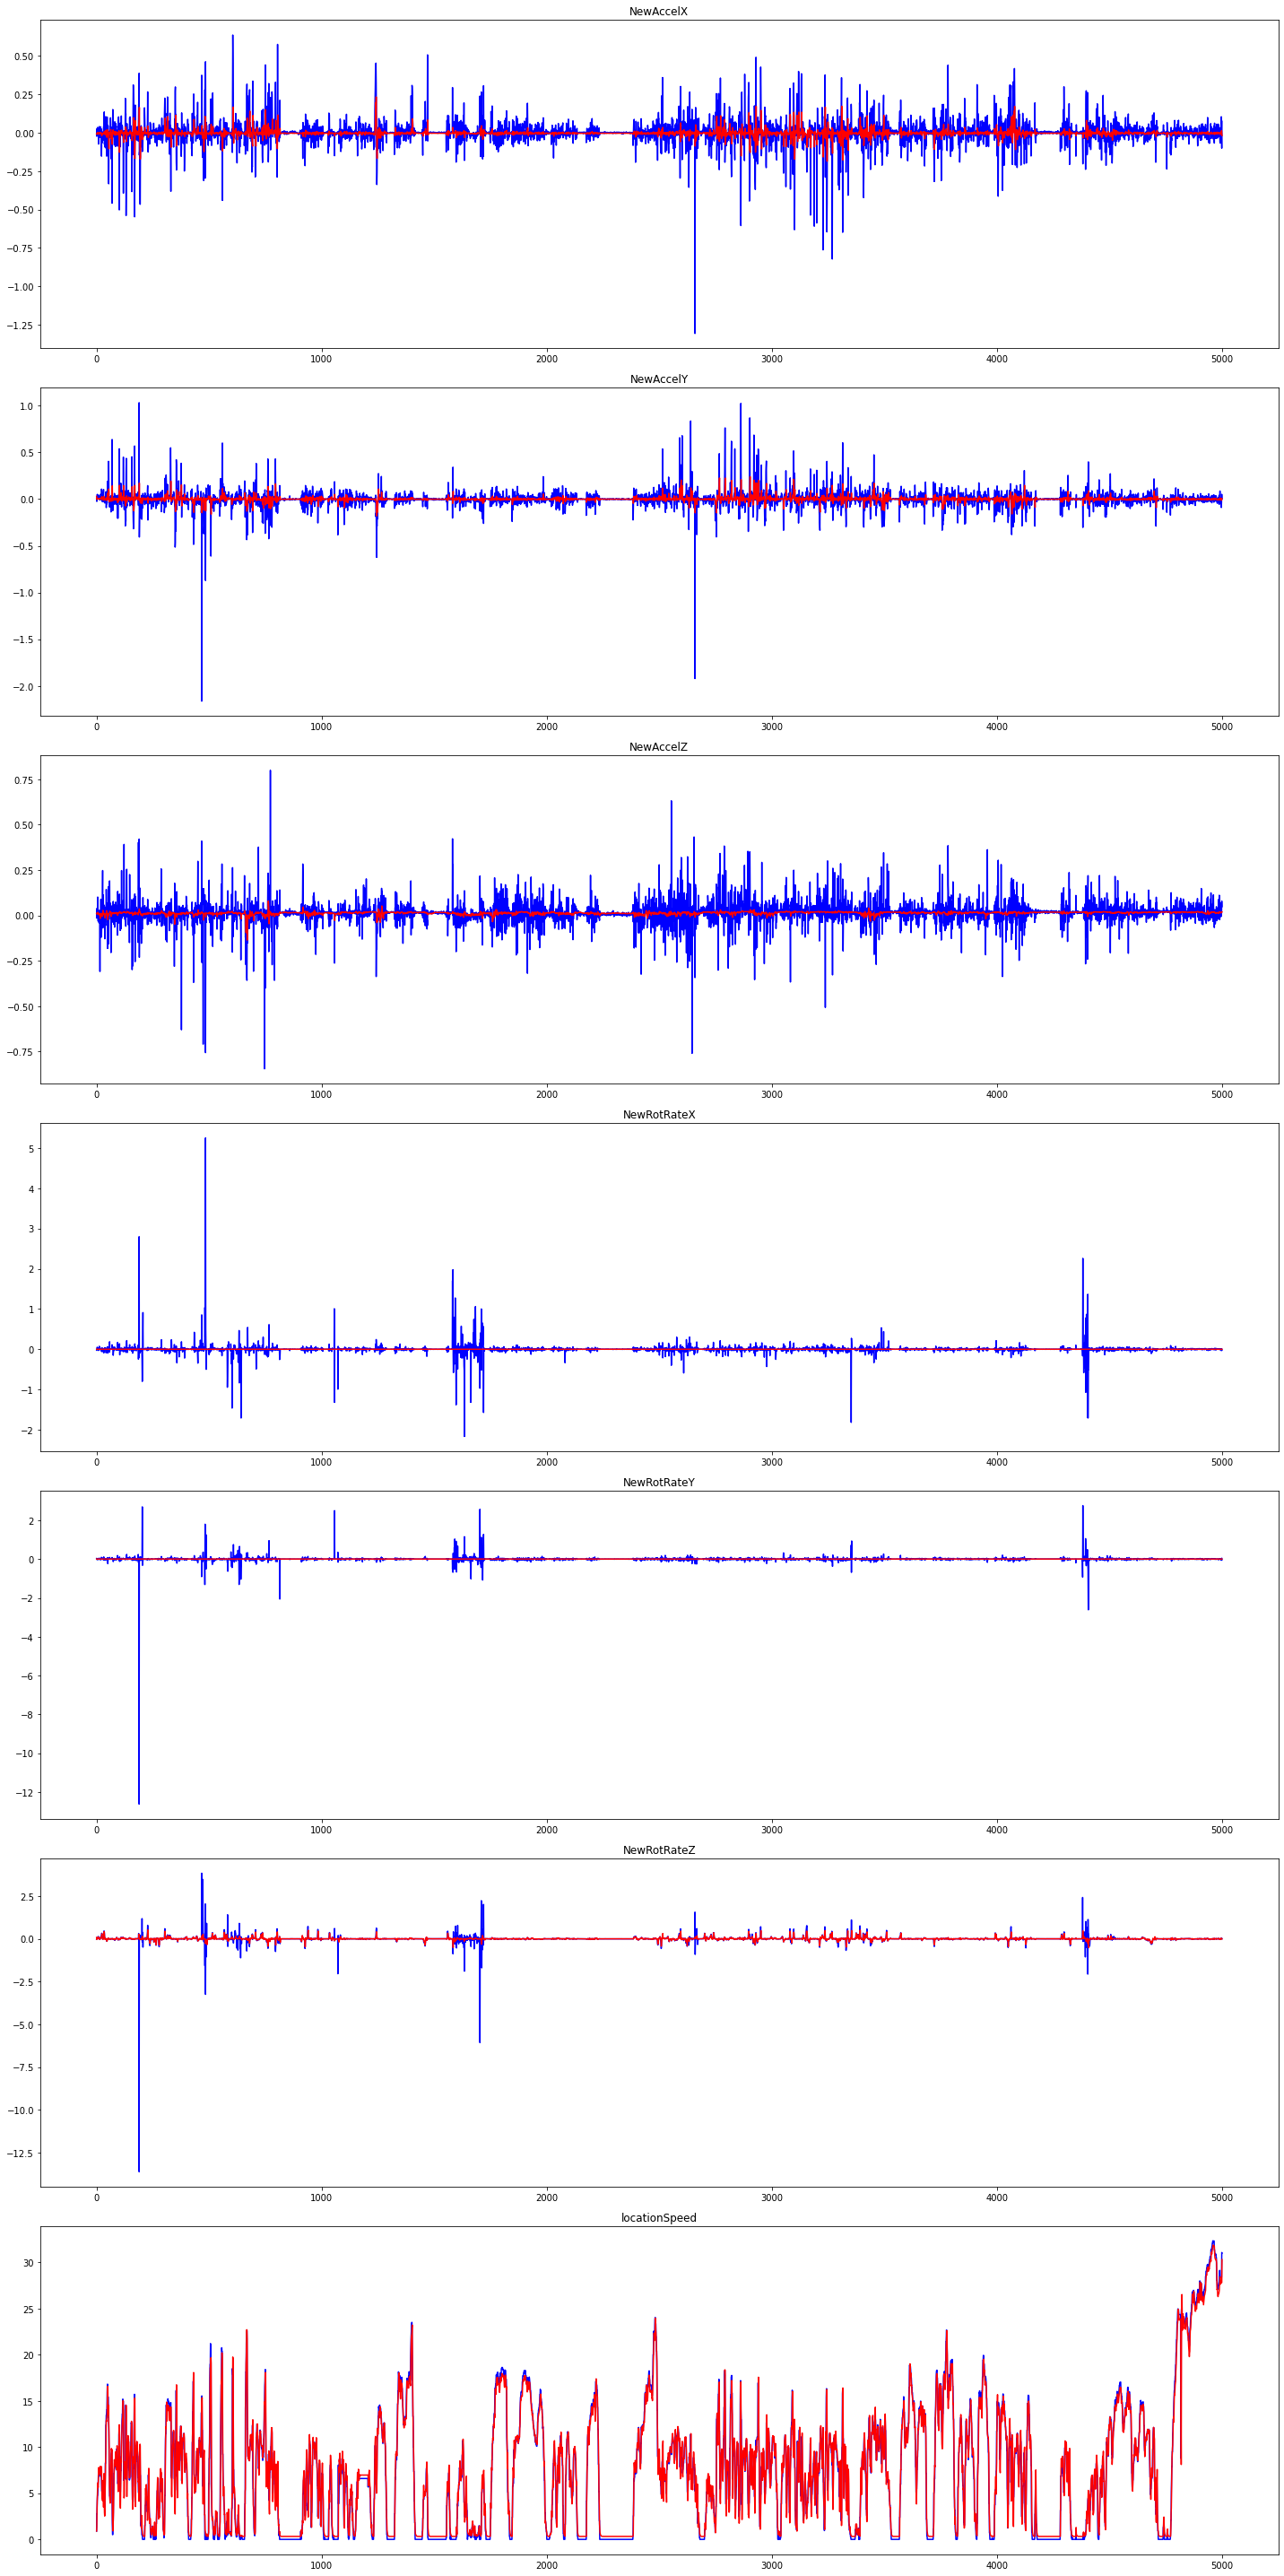

In [243]:
fig, axs = plt.subplots(k, 1, figsize=(20,40))
axs = axs.ravel()


def isof_plot(start,end):
    for i in range(k):
        axs[i].plot(df_new.iloc[start:end].index, df_new.iloc[start:end, i], color='blue')
        axs[i].plot(preds.iloc[start:end].index,preds.iloc[start:end,i],color='red')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

isof_plot(0,5000)

In [244]:
preds.to_csv('/content/drive/MyDrive/Data_Driven/preds_separete.csv')

In [247]:
def split_min_max1():

    '''
    sc = MinMaxScaler()
    df_tonos = pd.DataFrame(sc.fit_transform(df))
    '''

    n_past = 30
    n_future = 1 
    n_features = 7
    X_train, y_train = split_series(df.values,n_past, n_future)

    X_train1=X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
    y_train2 = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

    y_train1=y_train2[:, 0, :]
    return X_train1,y_train1#,sc

In [248]:
X_train2,y_train2=split_min_max1() #,trans2
print(X_train2.shape)
print(y_train2.shape)

(103861, 30, 7)
(103861, 7)


In [249]:
def lstm_AE2(train):
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (train.shape[1], train.shape[2])))
    model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 16, return_sequences = True))
    model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 8))
    model.add(Dropout(0.2))
# Adding the output layer
    model.add(Dense(units = 7))

# Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [250]:
model2=lstm_AE2(X_train2)
model2.fit(X_train2,y_train2, epochs=10, verbose=1)
pred2=model2.predict(X_train2)

Epoch 1/10
3246/3246 [==============================] - 33s 9ms/step - loss: 31.2976
Epoch 2/10
3246/3246 [==============================] - 28s 9ms/step - loss: 3.7878
Epoch 3/10
3246/3246 [==============================] - 28s 9ms/step - loss: 1.6855
Epoch 4/10
3246/3246 [==============================] - 28s 9ms/step - loss: 1.4047
Epoch 5/10
3246/3246 [==============================] - 28s 9ms/step - loss: 1.2511
Epoch 6/10
3246/3246 [==============================] - 28s 9ms/step - loss: 1.1396
Epoch 7/10
3246/3246 [==============================] - 29s 9ms/step - loss: 1.0779
Epoch 8/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.9825
Epoch 9/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.9444
Epoch 10/10
3246/3246 [==============================] - 28s 9ms/step - loss: 0.9106


In [251]:
#preds2=pd.DataFrame(trans2.inverse_transform(pred2))

preds2=pd.DataFrame(pred2)
print(preds2.shape)

(103861, 7)


In [252]:
for i in range(7):
  print("Column ",i," MSE: ",mean_squared_error(df_new.iloc[:,i], preds2.iloc[:,i]))

Column  0  MSE:  0.0033975816825685
Column  1  MSE:  0.003718112118417243
Column  2  MSE:  0.0040267351044268075
Column  3  MSE:  0.018188586880393365
Column  4  MSE:  0.016694580101995662
Column  5  MSE:  0.02150851669931179
Column  6  MSE:  0.6972191011736981


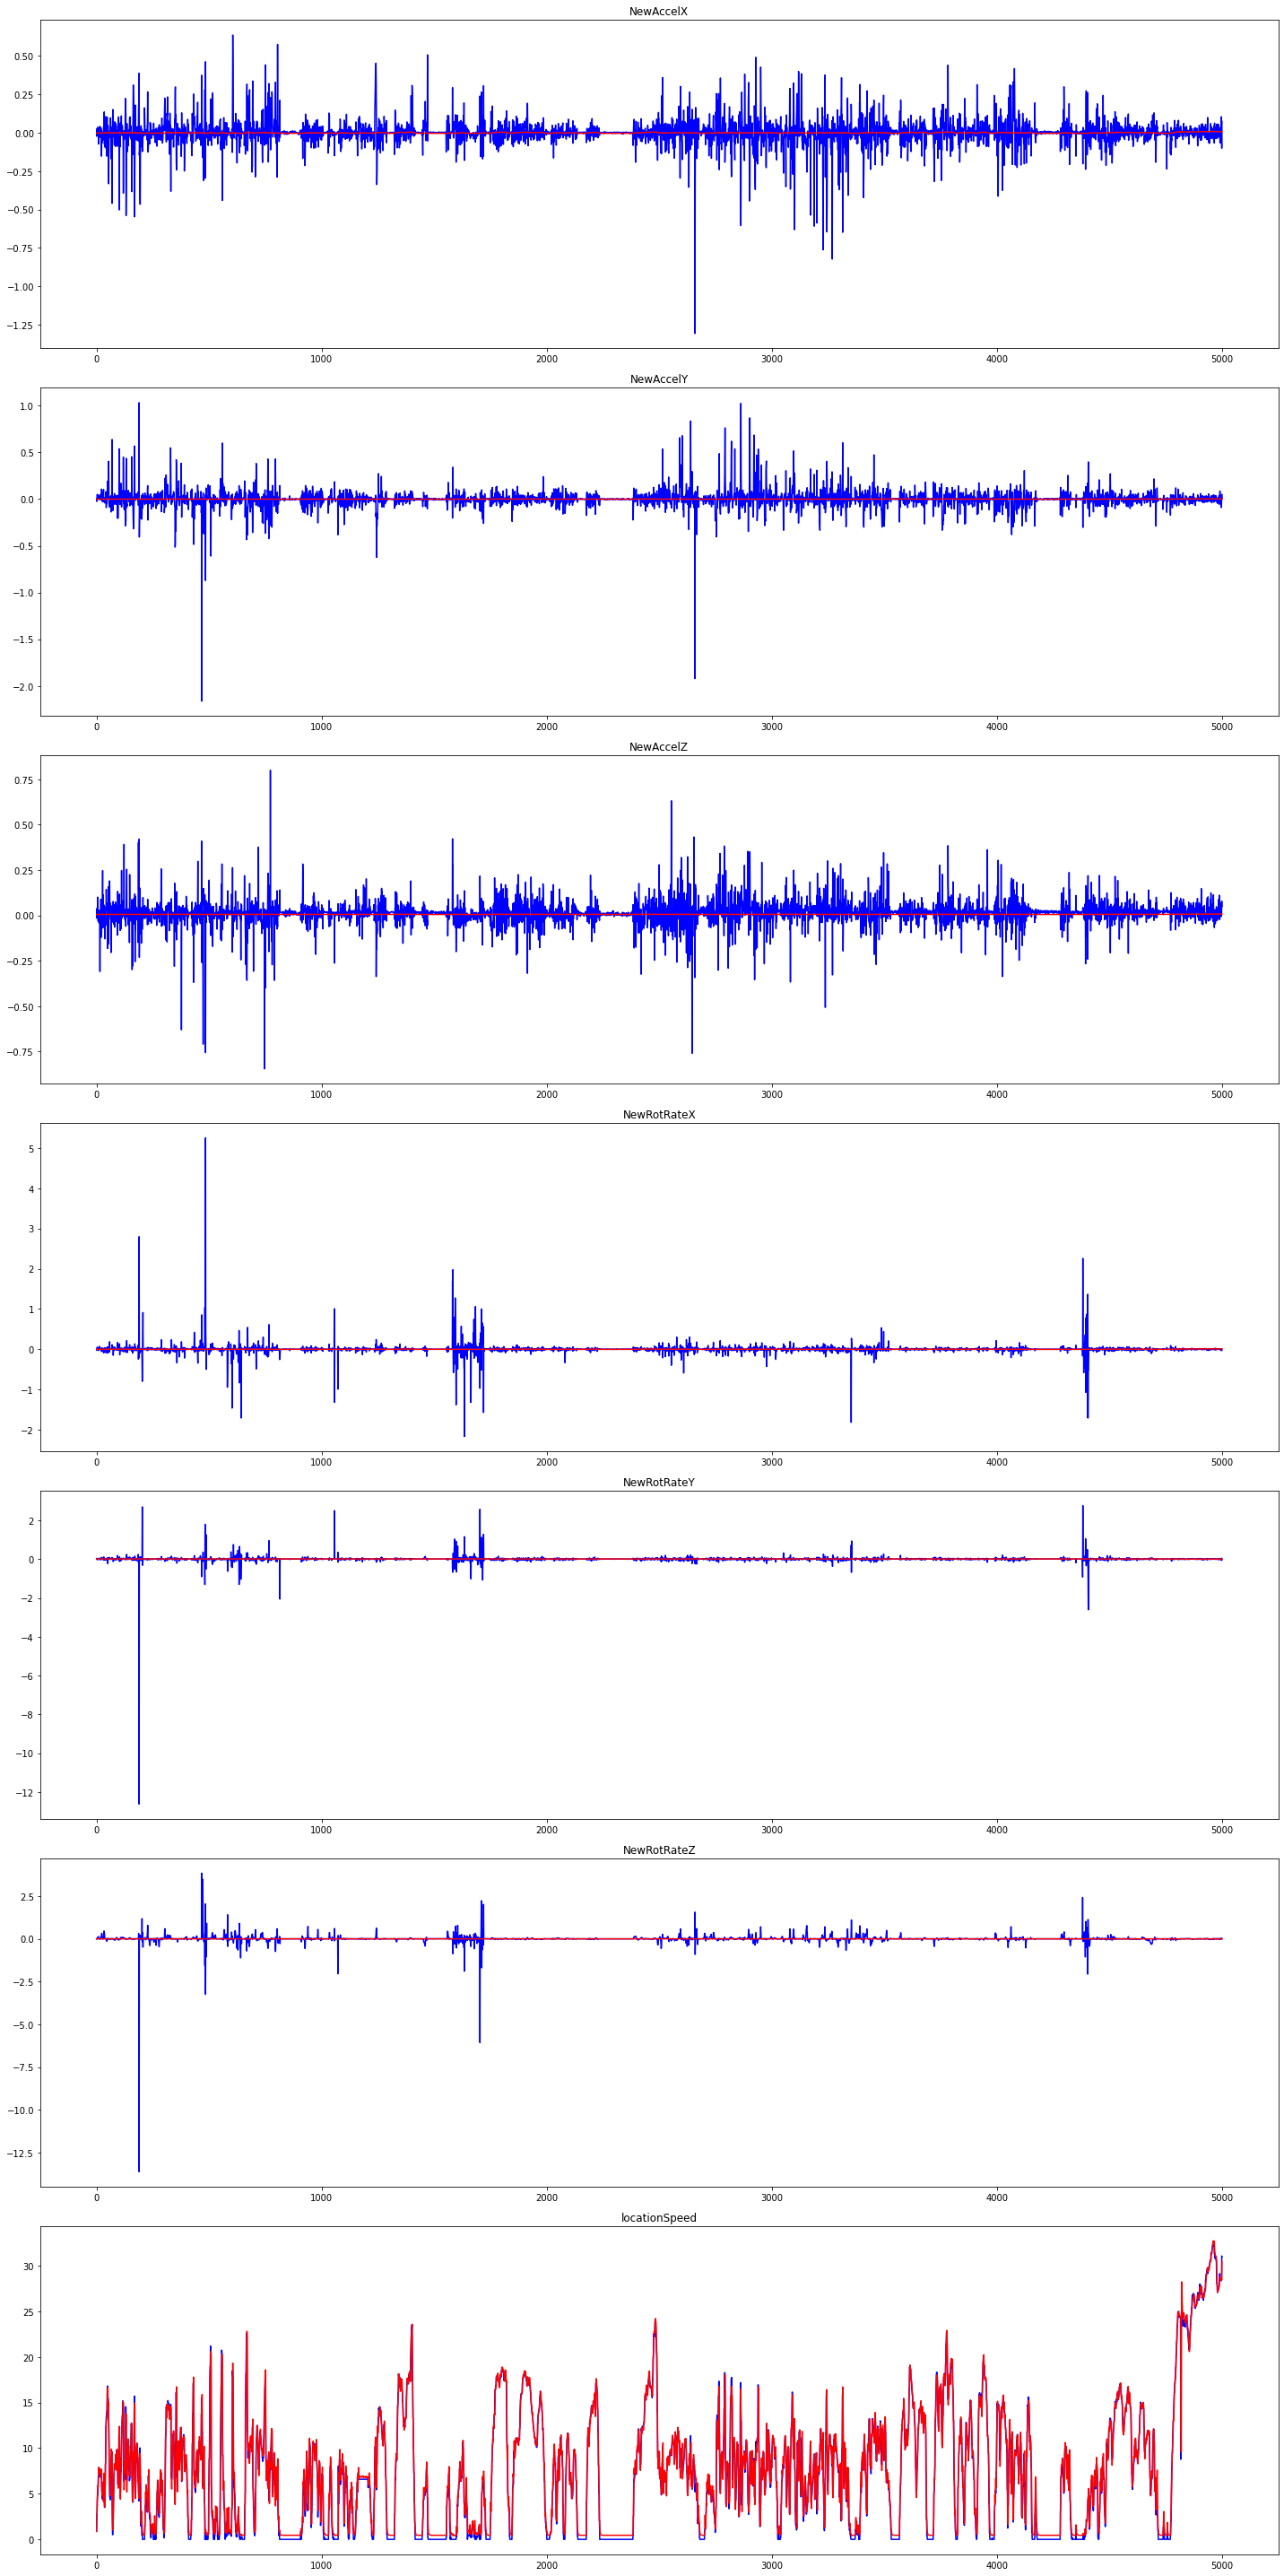

In [253]:
fig, axs = plt.subplots(7, 1, figsize=(20,40))
axs = axs.ravel()


def isof_plot(start,end):
    for i in range(7):
        axs[i].plot(df_new.iloc[start:end].index, df_new.iloc[start:end, i], color='blue')
        axs[i].plot(preds2.iloc[start:end].index,preds2.iloc[start:end,i],color='red')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

isof_plot(0,5000)

In [254]:
preds2.to_csv('/content/drive/MyDrive/Data_Driven/preds_together.csv')

Εχοντας πλεον στα χέρια μας τα 4 πακέτα χρονοσειρών θα προχωρήσουμε στο πως καθορισαμε τα outliers. Για κάθε στήλη βρήκαμε το MAE και στη συνέχεια όποιο στοιχείο απείχε απο το reconstructed του κάτα ένα ποσοστό * MAE τότε για αυτή τη στήλη θεωρείται outlier. Αν πάνω από 3 στήλες είναι ταξινομημένες ως outlier τότε όλο το σημείο είναι outlier. Τέλος επειδή θέλουμε να δώσουμε ίδια βαρύτητα σε όλους τους αλγορίθμους για την ανίχνευση outliers, ορίζουμε ότι αν σε τουλάχιστον μια χρονοσειρά ένα σημείο θεωρείται outlier τότε απο την γενική κατηγορία LSTM τίθεται ως outlier. Να σημειώσουμε ότι σε αυτή τη κατηγορία παρόλο τις εκπτώσεις που κάναμε βρέθηκαν λιγότερα outliers σε σχέση με τους προηγούμενους αλγορίθμους και το οπτικό αποτέλεσμα δεν είναι ιδιαίτερα ικανοποιητικό, παρόλα αυτά καθώς η συμβολή του αλγορίθμου είναι 16,6%, θεωρούμε ότι δεν μπορεί να αλλοιώσει τα προηγούμενα μας αποτελέσματα μας αλλά ίσως να προσθέσει κάποια εξτρά πληροφορία.

In [47]:
lstm_mm_sep=pd.read_csv('/content/drive/MyDrive/Data_Driven/preds_separete_min_max.csv')
lstm_mm_tog=pd.read_csv('/content/drive/MyDrive/Data_Driven/preds_together_min_max.csv')
lstm_sep=pd.read_csv('/content/drive/MyDrive/Data_Driven/preds_separete.csv')
lstm_tog=pd.read_csv('/content/drive/MyDrive/Data_Driven/preds_together.csv')

In [48]:
lstm_mm_sep=lstm_mm_sep.drop(["Unnamed: 0"],axis=1)
lstm_sep=lstm_sep.drop(["Unnamed: 0"],axis=1)
lstm_mm_tog=lstm_mm_tog.drop(["Unnamed: 0"],axis=1)
lstm_tog=lstm_tog.drop(["Unnamed: 0"],axis=1)

In [51]:
mae_loss_lstm_mm_sep=[]
for i in range(df_new.shape[1]):
  mae_loss_lstm_mm_sep.append(np.mean(np.abs(lstm_mm_sep.iloc[:,i] - df_new.iloc[:,i])))

mae_loss_lstm_sep=[]
for i in range(df_new.shape[1]):
  mae_loss_lstm_sep.append(np.mean(np.abs(lstm_sep.iloc[:,i] - df_new.iloc[:,i])))

mae_loss_lstm_mm_tog=[]
for i in range(df_new.shape[1]):
  mae_loss_lstm_mm_tog.append(np.mean(np.abs(lstm_mm_tog.iloc[:,i] - df_new.iloc[:,i])))

mae_loss_lstm_tog=[]
for i in range(df_new.shape[1]):
  mae_loss_lstm_tog.append(np.mean(np.abs(lstm_tog.iloc[:,i] - df_new.iloc[:,i])))



In [62]:
outlier_mm_sep=[]

threshold_mm_sep=0.8

for i in range(df_new.shape[1]):
  med=[]
  for j in range(df_new.shape[0]):
    if (np.abs(lstm_mm_sep.iloc[j,i] - df_new.iloc[j,i]> threshold_mm_sep*mae_loss_lstm_mm_sep[i])):
      med.append(-1)
    else:
      med.append(1)
  outlier_mm_sep.append(med)

print("Done")

outlier_sep=[]

threshold_sep=0.8

for i in range(df_new.shape[1]):
  med=[]
  for j in range(df_new.shape[0]):
    if (np.abs(lstm_sep.iloc[j,i] - df_new.iloc[j,i]> threshold_sep*mae_loss_lstm_sep[i])):
      med.append(-1)
    else:
      med.append(1)
  outlier_sep.append(med)


print("Done")

outlier_mm_tog=[]

threshold_mm_tog=0.8

for i in range(df_new.shape[1]):
  med=[]
  for j in range(df_new.shape[0]):
    if (np.abs(lstm_mm_tog.iloc[j,i] - df_new.iloc[j,i]> threshold_mm_tog*mae_loss_lstm_mm_tog[i])):
      med.append(-1)
    else:
      med.append(1)
  outlier_mm_tog.append(med)


print("Done")

outlier_tog=[]

threshold_tog=0.8

for i in range(df_new.shape[1]):
  med=[]
  for j in range(df_new.shape[0]):
    if (np.abs(lstm_tog.iloc[j,i] - df_new.iloc[j,i]> threshold_tog*mae_loss_lstm_tog[i])):
      med.append(-1)
    else:
      med.append(1)
  outlier_tog.append(med)

Done
Done
Done


In [63]:
temp=pd.DataFrame(np.array(outlier_mm_sep)).T
outlier_mm_sep=pd.DataFrame(data=np.array(temp),columns=['NewAccelX','NewAccelY','NewAccelZ','NewRotRateX','NewRotRateY','NewRotRateZ','locationSpeed'])


temp=pd.DataFrame(np.array(outlier_sep)).T
outlier_sep=pd.DataFrame(data=np.array(temp),columns=['NewAccelX','NewAccelY','NewAccelZ','NewRotRateX','NewRotRateY','NewRotRateZ','locationSpeed'])

temp=pd.DataFrame(np.array(outlier_mm_tog)).T
outlier_mm_tog=pd.DataFrame(data=np.array(temp),columns=['NewAccelX','NewAccelY','NewAccelZ','NewRotRateX','NewRotRateY','NewRotRateZ','locationSpeed'])

temp=pd.DataFrame(np.array(outlier_tog)).T
outlier_tog=pd.DataFrame(data=np.array(temp),columns=['NewAccelX','NewAccelY','NewAccelZ','NewRotRateX','NewRotRateY','NewRotRateZ','locationSpeed'])

In [64]:
outlier_mm_sep["final_outliers"]=0
for i in range(7):
    outlier_mm_sep["final_outliers"] += outlier_mm_sep.iloc[:, i]

outlier_sep["final_outliers"]=0
for i in range(7):
    outlier_sep["final_outliers"] += outlier_sep.iloc[:, i]

outlier_mm_tog["final_outliers"]=0
for i in range(7):
    outlier_mm_tog["final_outliers"] += outlier_mm_tog.iloc[:, i]

outlier_tog["final_outliers"]=0
for i in range(7):
    outlier_tog["final_outliers"] += outlier_tog.iloc[:, i]



print(outlier_mm_sep["final_outliers"].value_counts())
print(outlier_sep["final_outliers"].value_counts())
print(outlier_mm_tog["final_outliers"].value_counts())
print(outlier_tog["final_outliers"].value_counts())

 5    42883
 7    30292
 3    18257
 1     8309
-1     3113
-3      866
-5      134
-7        7
Name: final_outliers, dtype: int64
 7    38715
 5    32140
 3    19370
 1     9306
-1     3389
-3      835
-5      102
-7        4
Name: final_outliers, dtype: int64
 5    43581
 7    26739
 3    20008
 1     9095
-1     3373
-3      907
-5      147
-7       11
Name: final_outliers, dtype: int64
 5    42145
 3    23132
 7    20827
 1    11646
-1     4605
-3     1291
-5      197
-7       18
Name: final_outliers, dtype: int64


In [70]:
outlier_mm_sep['final']  = np.where(outlier_mm_sep['final_outliers']>=1, 1, -1)
outlier_sep['final']  = np.where(outlier_sep['final_outliers']>=1, 1, -1)
outlier_mm_tog['final']  = np.where(outlier_mm_tog['final_outliers']>=1, 1, -1)
outlier_tog['final']  = np.where(outlier_tog['final_outliers']>=1, 1, -1)

In [66]:
outlier_index_mm_sep=outlier_mm_sep[outlier_mm_sep["final"]==-1].index
outlier_index_sep=outlier_sep[outlier_mm_sep["final"]==-1].index
outlier_index_mm_tog=outlier_mm_tog[outlier_mm_sep["final"]==-1].index
outlier_index_tog=outlier_tog[outlier_mm_sep["final"]==-1].index

In [67]:
outlier_tog["sum_up"]=outlier_mm_sep["final"]+outlier_sep["final"]+outlier_mm_tog["final"]+outlier_tog["final"]

In [68]:
outlier["lstm"]=0
for i in range(outlier_tog.shape[0]):
  if outlier_tog["sum_up"].iloc[i]>=4:
    outlier['lstm'].iloc[i+30]=1
  else:
    outlier['lstm'].iloc[i+30]=-1

In [69]:
outlier["lstm"].value_counts()

 1    96242
-1     7619
 0       30
Name: lstm, dtype: int64

In [71]:
outlier_index_lstm=outlier[outlier["lstm"]==-1].index

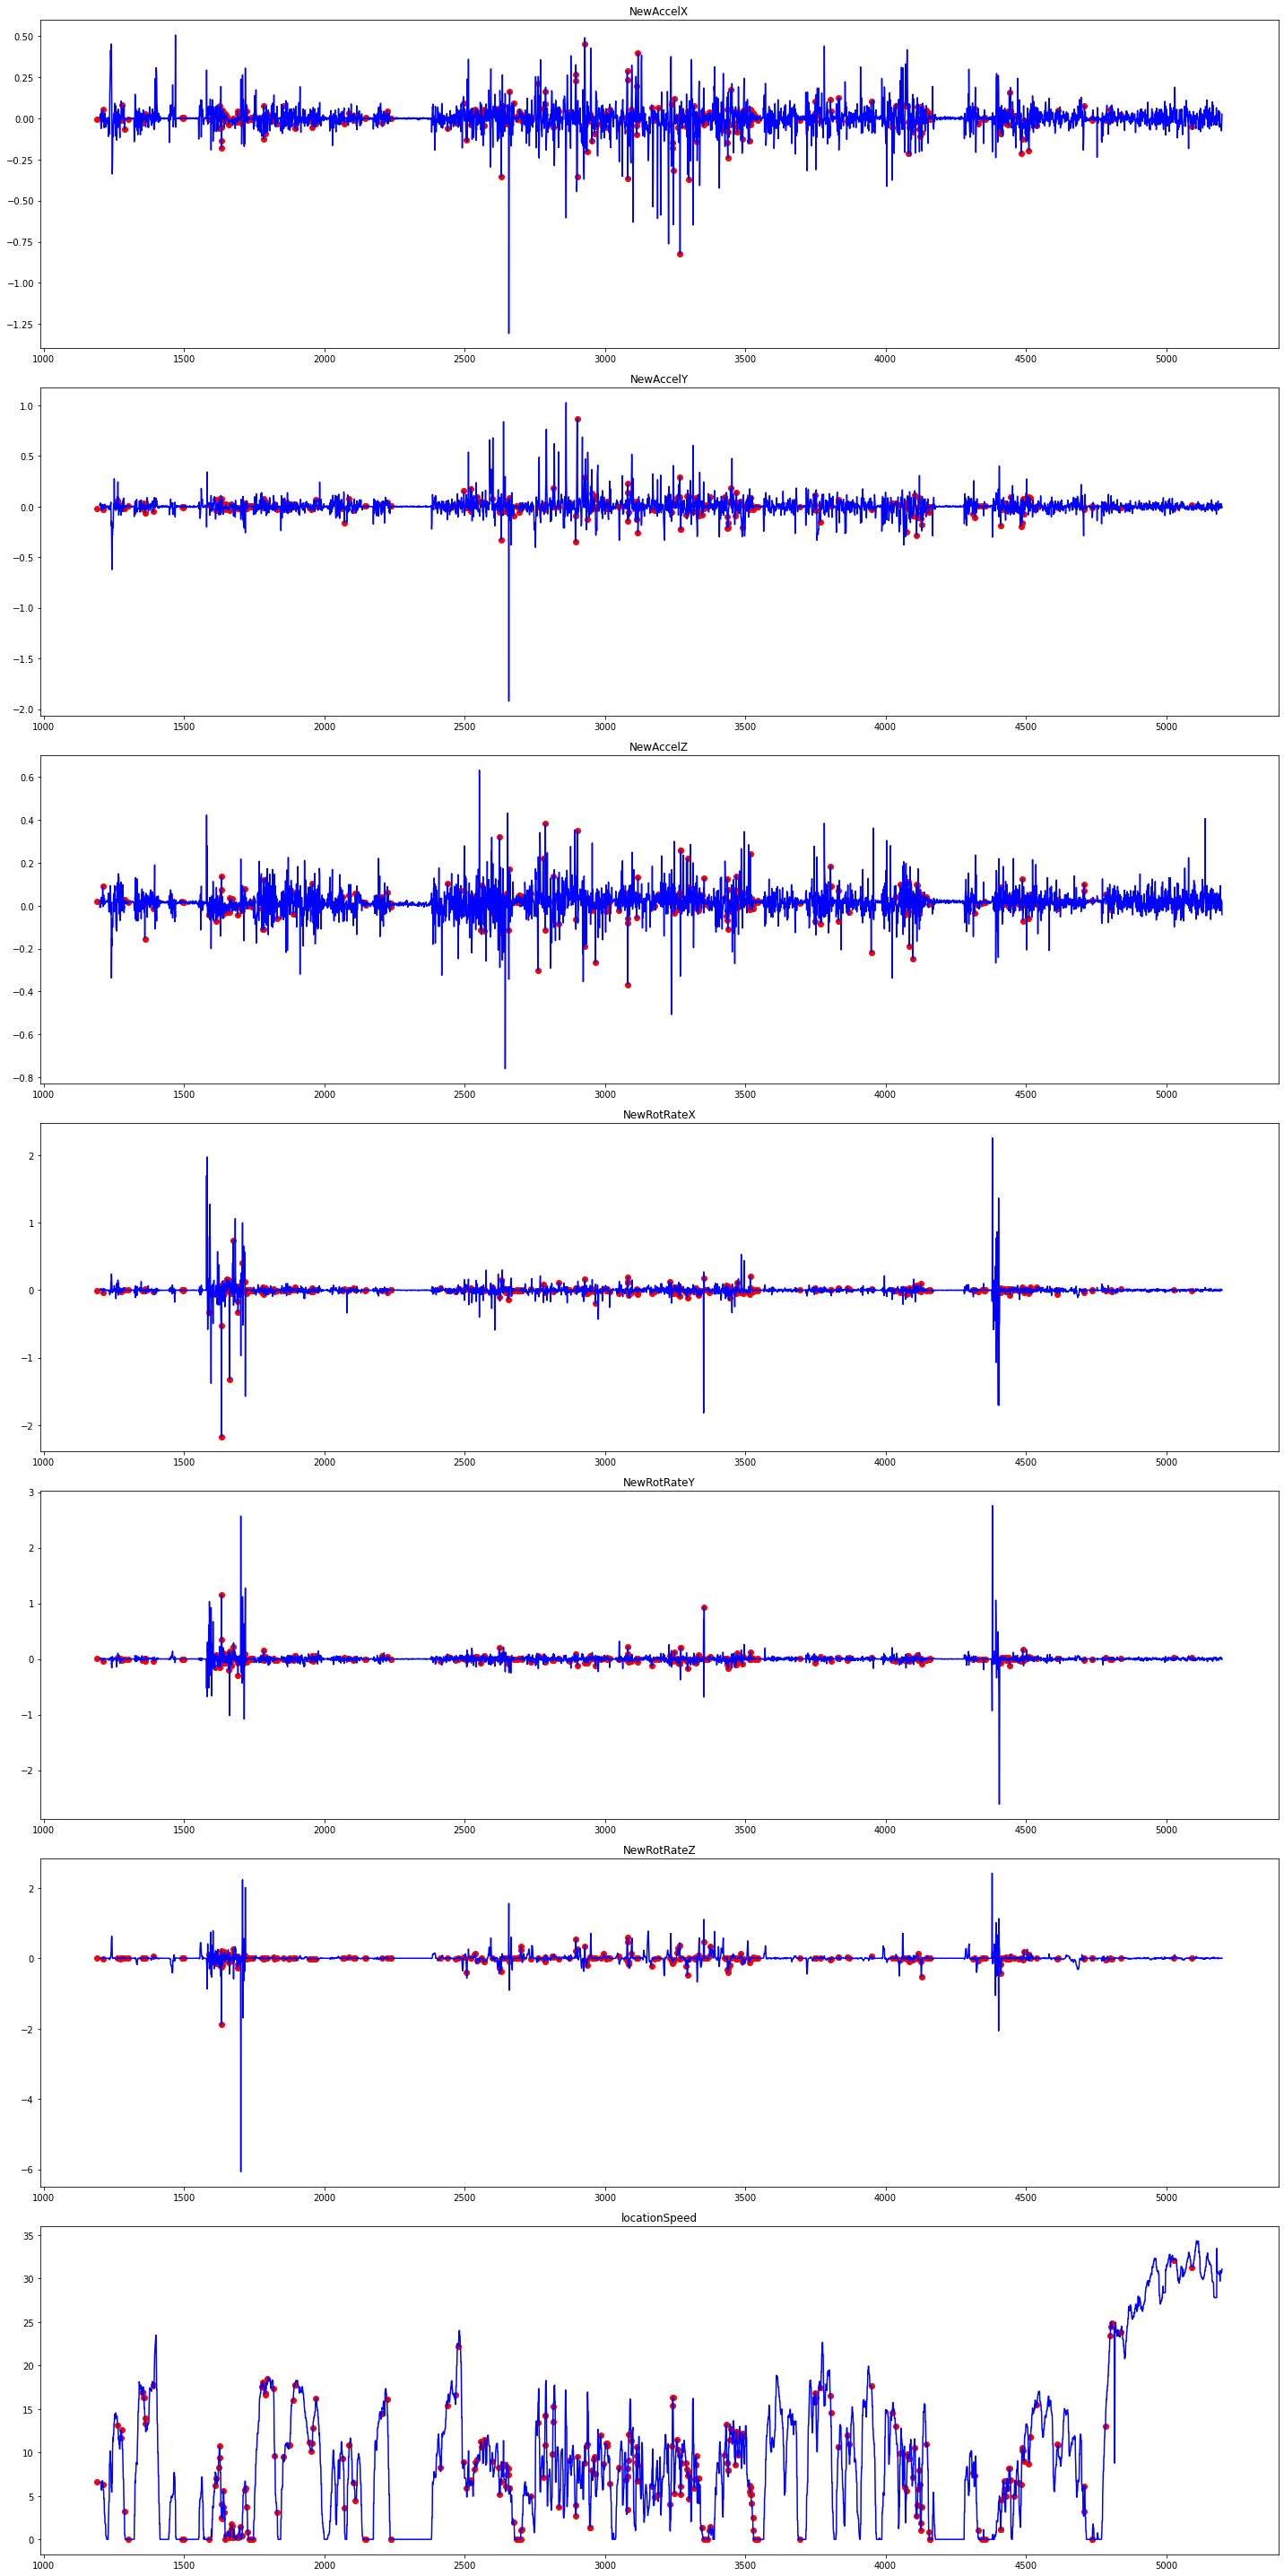

In [72]:
def lstm_plot(start1,end1,X):
    
    absolute_val_array = np.abs(X - start1)
    start2 = absolute_val_array.argmin()
    
    absolute_val_array = np.abs(X - end1)
    end2 = absolute_val_array.argmin()
    
    fig, axs = plt.subplots(7, 1, figsize=(20,40))
    axs = axs.ravel()
    
    for i in range(7):
        axs[i].plot(df_new.iloc[start1:end1].index, df_new.iloc[start1:end1, i], color='blue', label = 'Normal')
        axs[i].scatter(X[start2:end2], df_new.iloc[X[start2:end2],i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

lstm_plot(1200,5200,outlier_index_lstm)

### Final Estimation - Rules

Μέ τις εκτιμήσεις όλων των αλγορίθμων αποφασίζουμε να θέσουμε ως outlier ένα σημείο που τουλάχιστον 3 αλγόριθμοι το έχουν ταξινομήσει ως έτσι, δηλαδή το 50%.

Στο σημείο αυτό πρέπει να εκμεταλλευτούμε την ιδιότητα των harsh cornerings και να τα ξεχωρίσουμε από τα υπόλοιπα harsh events που έχουμε θέσει ως outliers.



*   Παρατηρήσαμε από την βιβλιογραφία ότι ενα harsh cornering χαρακτηρίζεται από μεγάλη απόλυτη τιμή επιτάχυνσης στον πλαϊνό άξονα (Υ). 
*   Επίσης θεωρήσαμε ότι στον άξονα Ζ πρέπει να υπάρχει μεγάλη απόλυτη τιμή του Rotation
*   Τέλος υποθέσαμε ότι σε ένα harsh cornering θα έχουμε αρνητική επιταχυνση στον άξονα της κίνησης (X) καθώς θα έχουμε μείωση της ταχύτητας.

Αυτοί είναι και οι 3 κανόνες που εφαρμόσαμε για να καταλήξουμε στα τελικά μας συμπεράσματα.

In [89]:
outlier["sum"]=outlier["knn"]+outlier["lof"]+outlier["isof"]+outlier["kmeans"]+outlier["AE"]+outlier["lstm"]
outlier["sum"].value_counts()

 6    71142
 4    17482
-2     5273
 0     4024
 2     3385
-4     2353
-6      232
Name: sum, dtype: int64

In [90]:
outlier["lstm"].replace(0, 1, inplace = True)

In [91]:
count_outl = outlier[(outlier["knn"] == -1) &
              (outlier["lof"] == -1) &
              (outlier["isof"] == -1) &
              (outlier["kmeans"] == -1)&
              (outlier["AE"] == -1)&
              (outlier["lstm"] == -1)]

In [92]:
count_outl.shape

(232, 8)

In [93]:
outlier["semi_final"]=np.where(outlier['sum']>0, 1, -1)
df["semi_final"]=outlier["semi_final"]

In [94]:
threshold_accY=0.7
threshold_rotZ=0.7

# OUTLIERS=1
df["final"]=0

for i in range(df.shape[0]):
  if ((df["semi_final"].iloc[i]==-1) and 
      (df["NewAccelX"].iloc[i] <= 0) and 
      (abs(df["NewAccelY"].iloc[i] - np.mean(df["NewAccelY"])) >= threshold_accY*np.std(df["NewAccelY"])) and
      (abs(df["NewRotRateZ"].iloc[i] - np.mean(df["NewRotRateZ"])) >= threshold_rotZ*np.std(df["NewRotRateZ"]))):
    df['final'].iloc[i]=1


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [95]:
df['final'].value_counts()

0    102085
1      1806
Name: final, dtype: int64

In [96]:
outlier_final=df[df["final"]==1].index

In [97]:
df.iloc[outlier_final]

NewAccelX  NewAccelY  NewAccelZ  ...  locationSpeed  final  semi_final
29         -0.064      0.127      0.008  ...           0.89      1          -1
52         -0.153      0.108     -0.105  ...           6.02      1          -1
75         -0.153     -0.051     -0.036  ...          14.01      1          -1
223        -0.466     -0.202     -0.101  ...          10.02      1          -1
224        -0.466     -0.202     -0.101  ...           6.91      1          -1
...           ...        ...        ...  ...            ...    ...         ...
103811     -0.128      0.180      0.027  ...           7.92      1          -1
103824     -0.006      0.066      0.171  ...           5.68      1          -1
103837     -0.160     -0.399      0.142  ...           5.35      1          -1
103845     -0.141      0.248      0.203  ...           4.81      1          -1
103850     -0.068     -0.213     -0.089  ...           3.25      1          -1

[1806 rows x 9 columns]

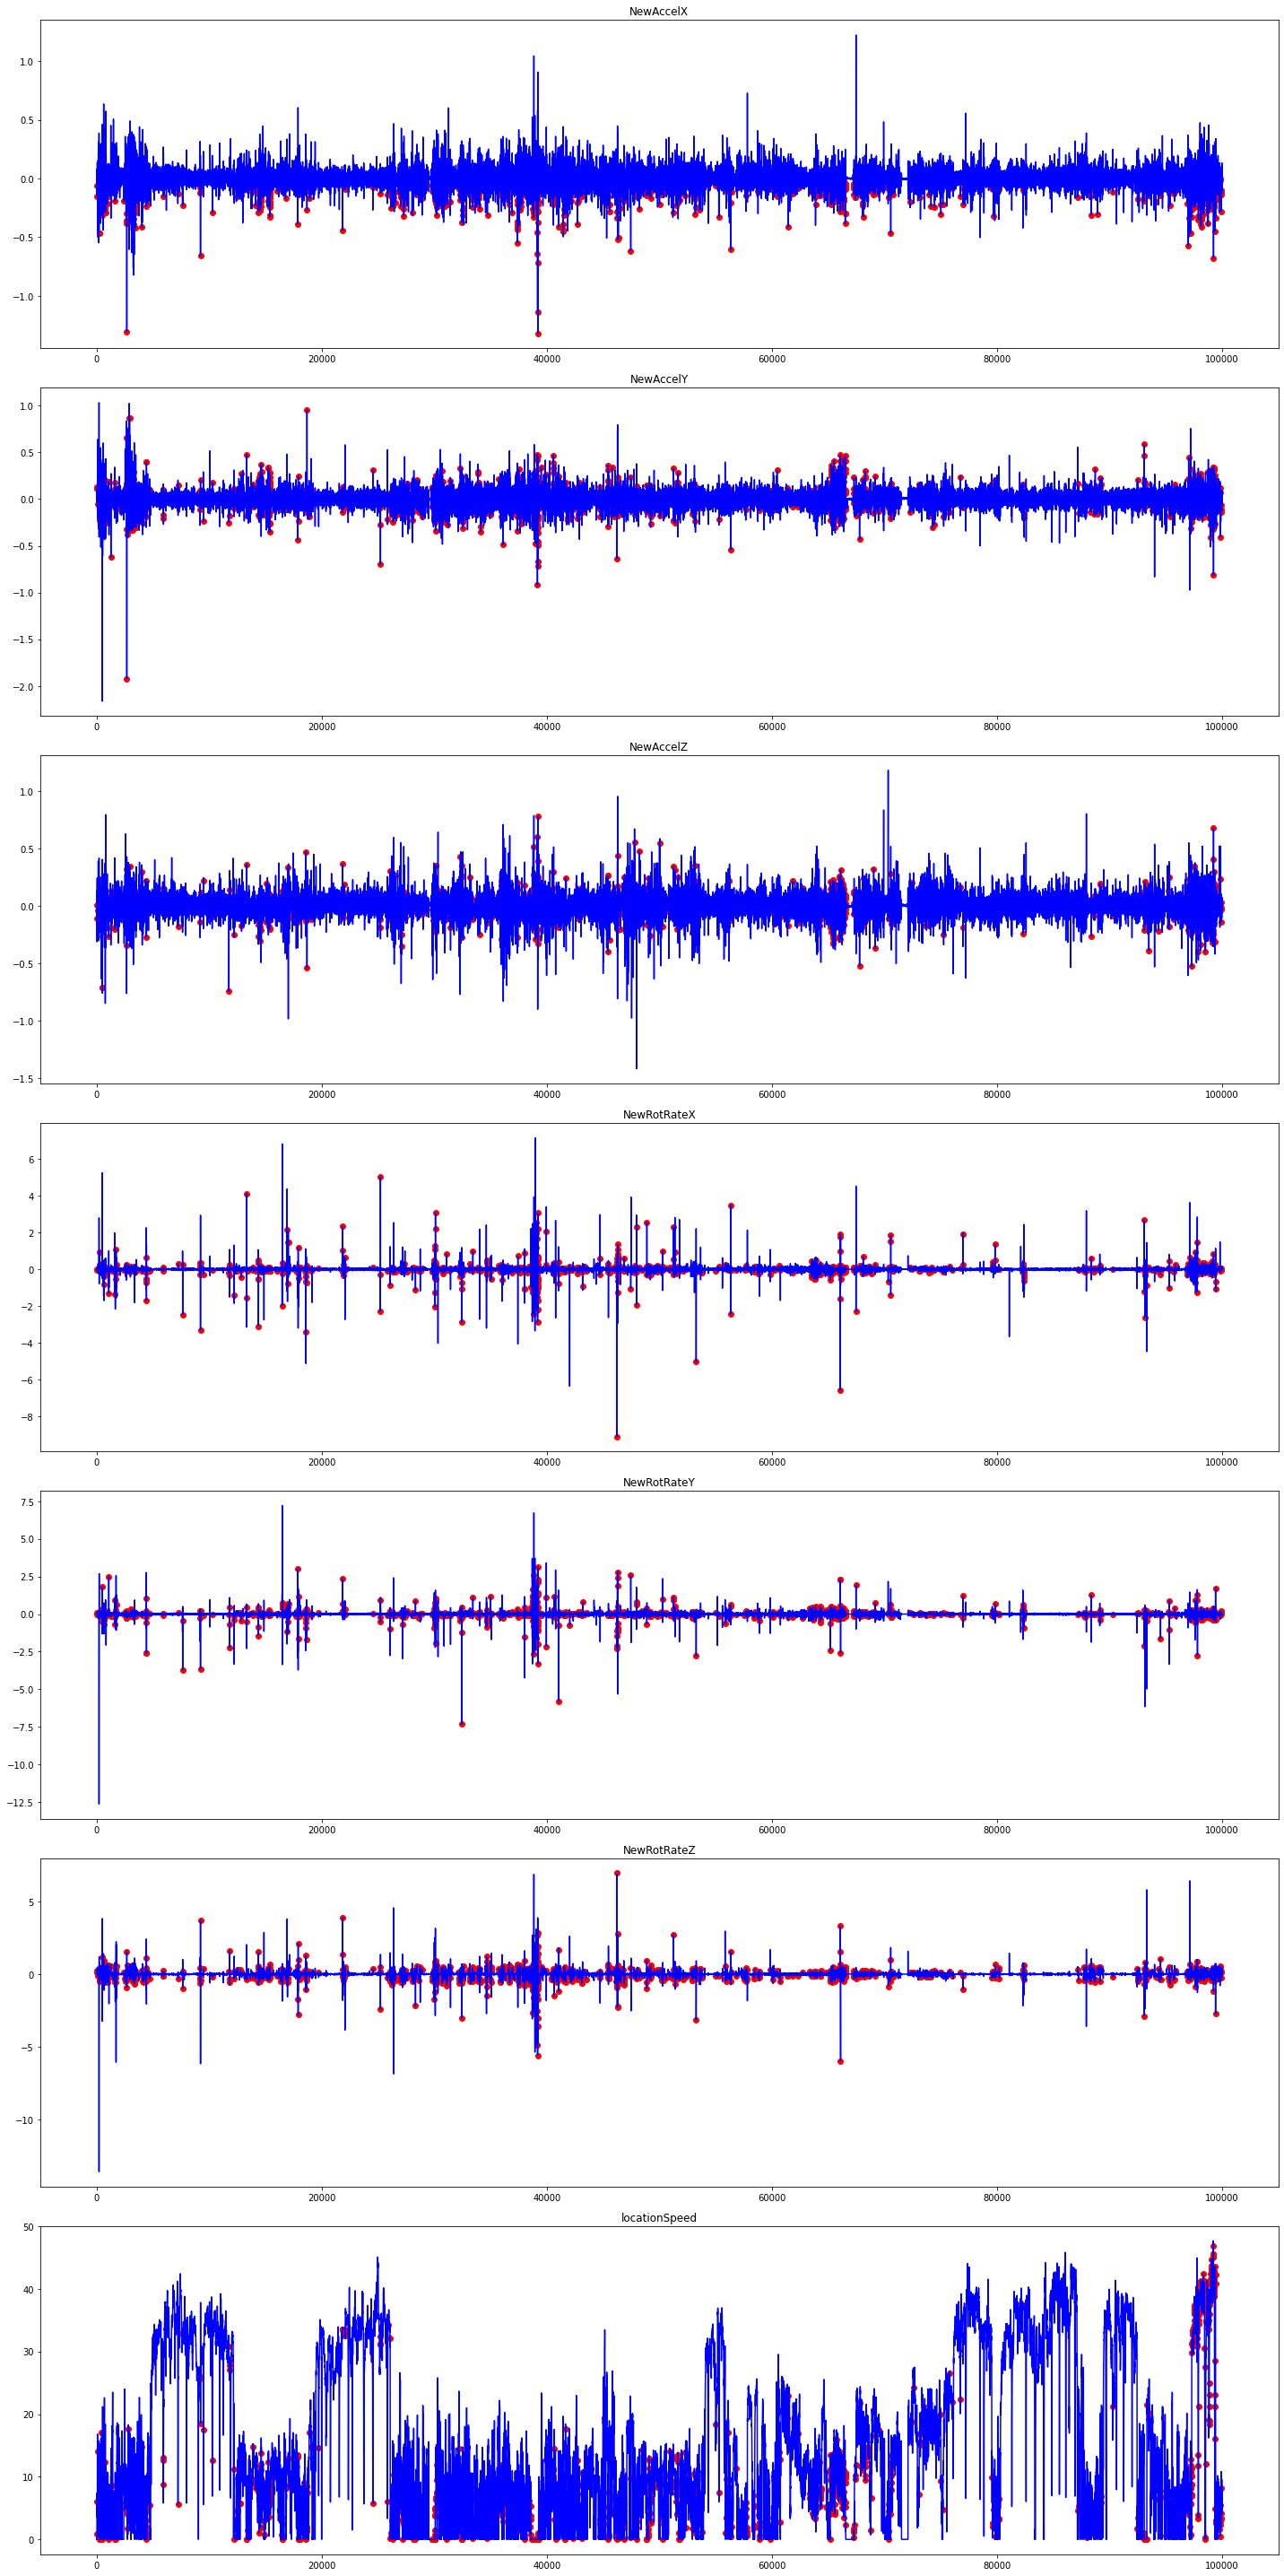

In [98]:
def final_plot(start1,end1,X):
    
    absolute_val_array = np.abs(X - start1)
    start2 = absolute_val_array.argmin()
    
    absolute_val_array = np.abs(X - end1)
    end2 = absolute_val_array.argmin()
    
    fig, axs = plt.subplots(7, 1, figsize=(20,40))
    axs = axs.ravel()
    
    for i in range(7):
        axs[i].plot(df.iloc[start1:end1].index, df.iloc[start1:end1, i], color='blue', label = 'Normal')
        axs[i].scatter(X[start2:end2], df.iloc[X[start2:end2],i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

final_plot(0,100000,outlier_final)

Τελικά το συνολικά πλήθος των σημείων μας είναι 1806, δηλαδή το 2.7% των δεδομένων μας.

In [99]:
df=df.drop(columns=['semi_final'])
df=df.rename(columns={"final": "Outlier"})
df.to_csv('/content/drive/MyDrive/Data_Driven/final.csv',index=False)